# EDE2 - Semester Project
 ### Time Series Analysis - Solar Power Generation in Germany

Student name: 
- Fjolla Fazliu, 
- Akin Tarakci,
- Saeed Sohbatloo


![Solar Power Plant Distribution](GermanySolar.png)


# Data Preparation 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import numpy as np

import warnings
warnings.filterwarnings('ignore')

In [2]:
input_paths = [
    "energy-charts_Total_net_electricity_generation_in_Germany_in_2021.csv",
    "energy-charts_Total_net_electricity_generation_in_Germany_in_2022.csv",
    "energy-charts_Total_net_electricity_generation_in_Germany_in_2023.csv",
    "energy-charts_Total_net_electricity_generation_in_Germany_in_2024.csv",
    "energy-charts_Total_net_electricity_generation_in_Germany_in_2025.csv",
]


In [3]:
# Load all files into separate DataFrames with low_memory=False 
dfs = [pd.read_csv(path, low_memory=False) for path in input_paths]

# Concatenate all DataFrames into one
df_all = pd.concat(dfs, ignore_index=True)
df_all = df_all.sort_index()


In [4]:
# Select only the columns "Date (GMT+1)" and "Solar"
df_solar = df_all[["Date (GMT+1)", "Solar"]]

# Optional: Clean column names (strip any leading/trailing spaces)
df_solar.columns = df_solar.columns.str.strip()

# Optional: Check the result
print(df_solar.head())

             Date (GMT+1)       Solar
0                     NaN  Power (MW)
1  2021-01-01T00:00+01:00           0
2  2021-01-01T00:15+01:00           0
3  2021-01-01T00:30+01:00           0
4  2021-01-01T00:45+01:00           0


In [5]:
# Load your data (if not already loaded)
# df_solar = pd.read_csv('your_file.csv')

# Remove any accidental spaces from column names
df_solar.columns = df_solar.columns.str.strip()

# Rename columns
df_solar = df_solar.rename(columns={"Date (GMT+1)": "Date-Time", "Solar": "Solar-Power-MW"})

# Convert 'Date-Time' to datetime
df_solar["Date-Time"] = pd.to_datetime(df_solar["Date-Time"], utc=True)

# Remove timezone
df_solar["Date-Time"] = df_solar["Date-Time"].dt.tz_localize(None)

# Make 'Solar-Power-MW' numeric
df_solar["Solar-Power-MW"] = pd.to_numeric(df_solar["Solar-Power-MW"], errors="coerce")

# Set Date-Time as index
df_solar = df_solar.set_index('Date-Time')

# Check
print(df_solar.head())
print(df_solar.index)


                     Solar-Power-MW
Date-Time                          
NaT                             NaN
2020-12-31 23:00:00             0.0
2020-12-31 23:15:00             0.0
2020-12-31 23:30:00             0.0
2020-12-31 23:45:00             0.0
DatetimeIndex([                'NaT', '2020-12-31 23:00:00',
               '2020-12-31 23:15:00', '2020-12-31 23:30:00',
               '2020-12-31 23:45:00', '2021-01-01 00:00:00',
               '2021-01-01 00:15:00', '2021-01-01 00:30:00',
               '2021-01-01 00:45:00', '2021-01-01 01:00:00',
               ...
               '2025-04-18 13:00:00', '2025-04-18 13:15:00',
               '2025-04-18 13:30:00', '2025-04-18 13:45:00',
               '2025-04-18 14:00:00', '2025-04-18 14:15:00',
               '2025-04-18 14:30:00', '2025-04-18 14:45:00',
               '2025-04-18 15:00:00', '2025-04-18 15:15:00'],
              dtype='datetime64[ns]', name='Date-Time', length=150599, freq=None)


In [6]:
df_solar.describe()

Solar-Power-MW
count   150594.000000
mean      6995.386827
std      10812.629715
min          0.000000
25%          0.000000
50%         95.000000
75%      11357.900000
max      53288.400000

In [7]:
# Check for missing values (nulls) in each column
missing_values = df_solar.isnull().sum()

# Print missing values
print(missing_values)


Solar-Power-MW    5
dtype: int64


In [8]:

# Find rows where 'Solar-Power-MW' is null
null_solar = df_solar[df_solar['Solar-Power-MW'].isnull()]

# Combine both filters to find rows where either column is null
null_rows = df_solar[ df_solar['Solar-Power-MW'].isnull()]

# Print the rows with missing values in either column
print(null_rows)


           Solar-Power-MW
Date-Time                
NaT                   NaN
NaT                   NaN
NaT                   NaN
NaT                   NaN
NaT                   NaN


In [9]:
# Drop rows where either 'Date-Time' or 'Solar-Power-MW' is null
df_solar = df_solar.dropna(subset=['Solar-Power-MW'])
df_modeling=df_solar

# Check the result
print(df_solar.head())


                     Solar-Power-MW
Date-Time                          
2020-12-31 23:00:00             0.0
2020-12-31 23:15:00             0.0
2020-12-31 23:30:00             0.0
2020-12-31 23:45:00             0.0
2021-01-01 00:00:00             0.0


In [12]:
# Create train (before 2025) and test (only 2025) sets
df_solar_2025 = df_solar[df_solar.index.year == 2025]
df_solar = df_solar[df_solar.index.year < 2025]

# Check the results
print("df_solar (train):", df_solar.shape)
print("df_solar_2025 (test):", df_solar_2025.shape)


df_solar (train): (140260, 1)
df_solar_2025 (test): (10334, 1)


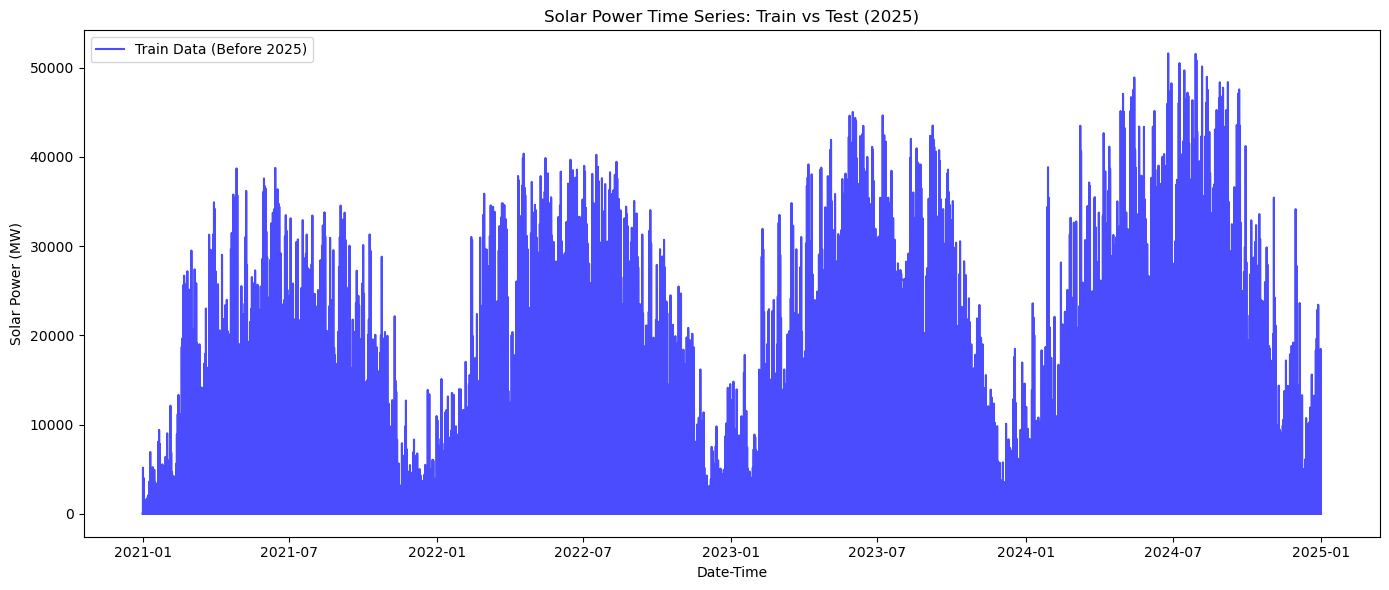

In [13]:
plt.figure(figsize=(14, 6))

# Plot training data
plt.plot(df_solar.index, df_solar['Solar-Power-MW'], label='Train Data (Before 2025)', color='blue', alpha=0.7)

# Plot test data
#plt.plot(df_solar_2025.index, df_solar_2025['Solar-Power-MW'], label='Test Data (2025)', color='red', alpha=0.7)

plt.xlabel('Date-Time')
plt.ylabel('Solar Power (MW)')
plt.title('Solar Power Time Series: Train vs Test (2025)')
plt.legend()
plt.tight_layout()
plt.show()


# Exploratory Data analysis - original time series

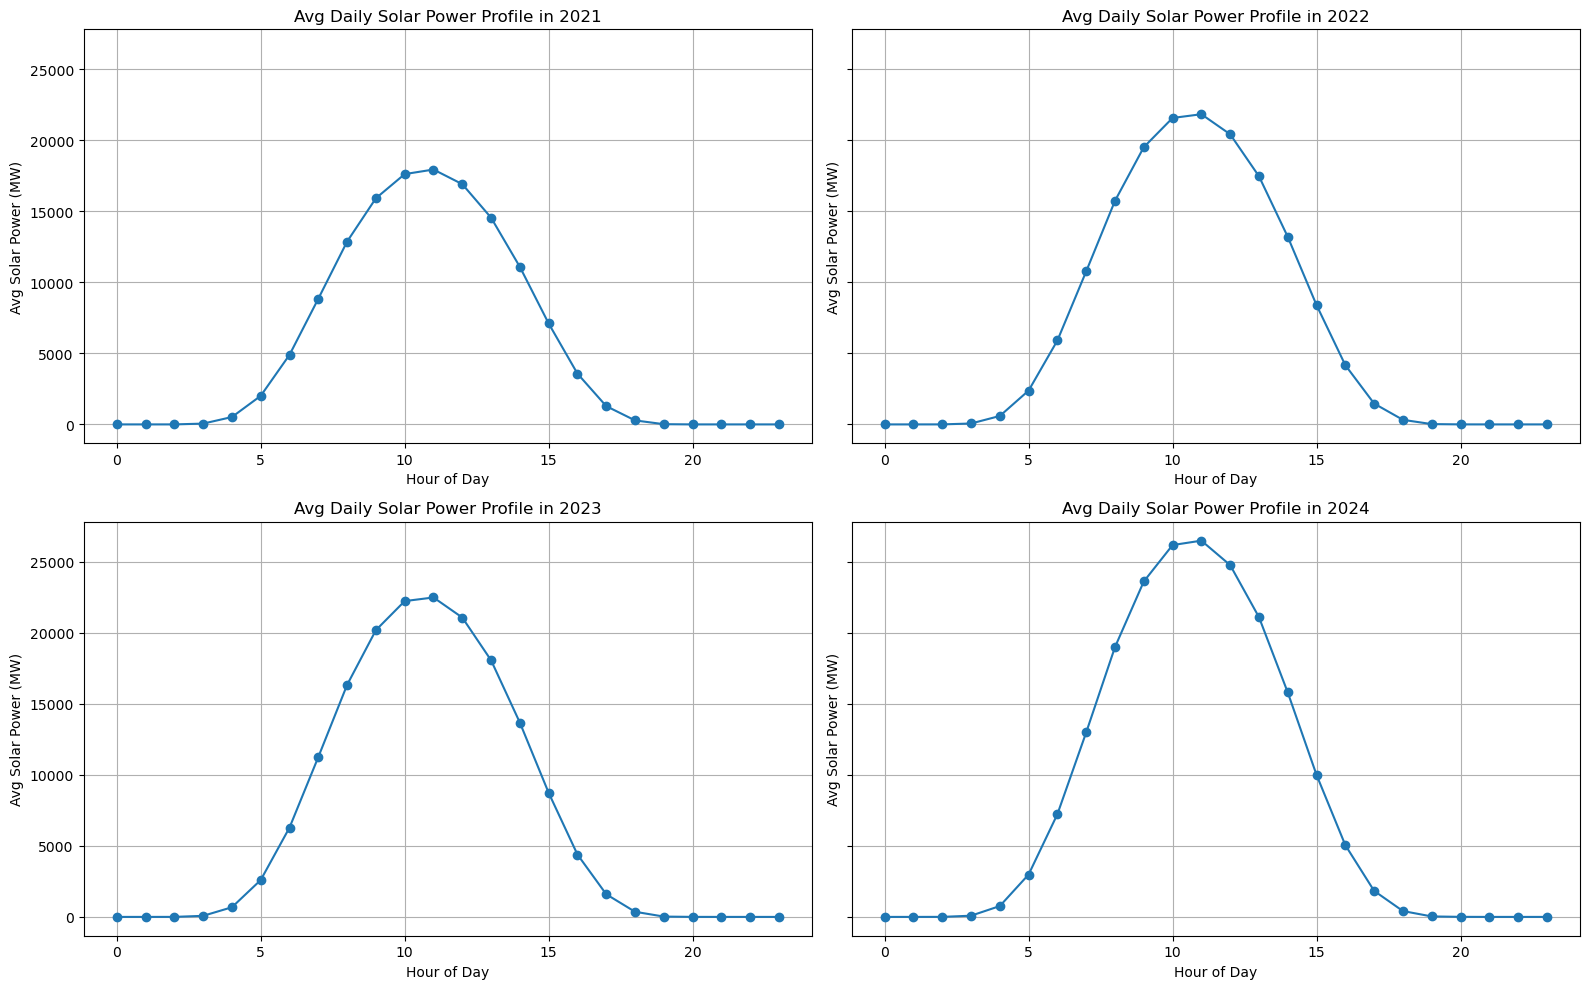

In [14]:
# Ensure index is datetime
df_solar.index = pd.to_datetime(df_solar.index)

# Define the years
years = [2021, 2022, 2023, 2024]

# Create 2x2 subplots
fig, axes = plt.subplots(2, 2, figsize=(16, 10), sharey=True)

# Flatten axes array
axes = axes.flatten()

# Loop through each year and plot
for i, year in enumerate(years):
    df_year = df_solar[df_solar.index.year == year]
    daily_avg = df_year.groupby(df_year.index.hour)['Solar-Power-MW'].mean()
    
    axes[i].plot(daily_avg.index, daily_avg.values, marker='o')
    axes[i].set_title(f"Avg Daily Solar Power Profile in {year}")
    axes[i].set_xlabel("Hour of Day")
    axes[i].set_ylabel("Avg Solar Power (MW)")
    axes[i].grid(True)

plt.tight_layout()
plt.show()




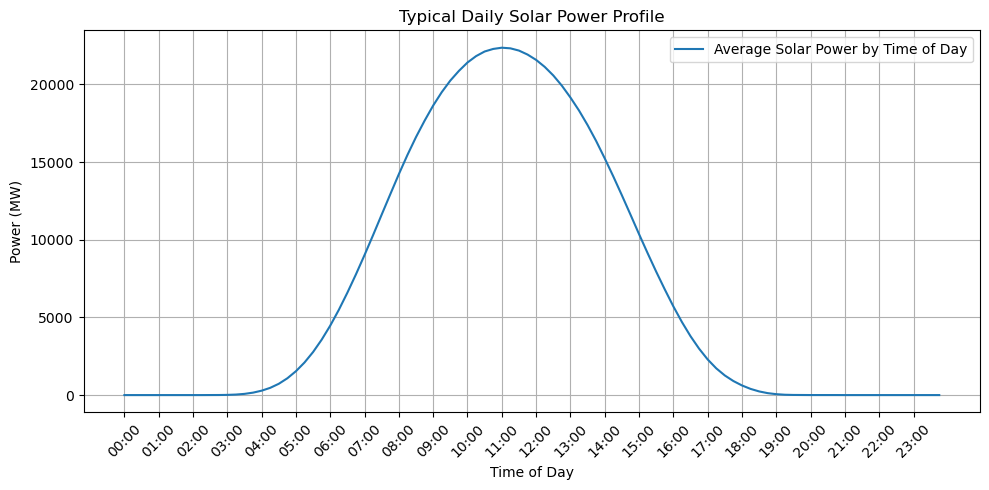

In [15]:
# Assuming df_solar already has the Date-Time index and Solar-Power-MW column

# Create "time of day" feature from the index
df_solar['time_of_day'] = df_solar.index.time

# Convert time_of_day to minutes since midnight (or hours as a float)
df_solar['time_of_day_in_minutes'] = df_solar['time_of_day'].apply(lambda x: x.hour * 60 + x.minute)

# Group by time of day and calculate the average
avg_profile = df_solar.groupby('time_of_day_in_minutes')['Solar-Power-MW'].mean()

# Plot
plt.figure(figsize=(10,5))
plt.plot(avg_profile.index, avg_profile.values, label='Average Solar Power by Time of Day')

# Convert x-ticks to time format (HH:MM) for better readability
plt.xticks(
    ticks=range(0, 24*60, 60),  # Tick every hour
    labels=[f'{i//60:02d}:{i%60:02d}' for i in range(0, 24*60, 60)]  # Format as HH:MM
)

# Title and labels
plt.title('Typical Daily Solar Power Profile')
plt.xlabel('Time of Day')
plt.ylabel('Power (MW)')
plt.grid(True)
plt.xticks(rotation=45)
plt.legend()

# Tight layout for better fitting
plt.tight_layout()

# Show the plot
plt.show()


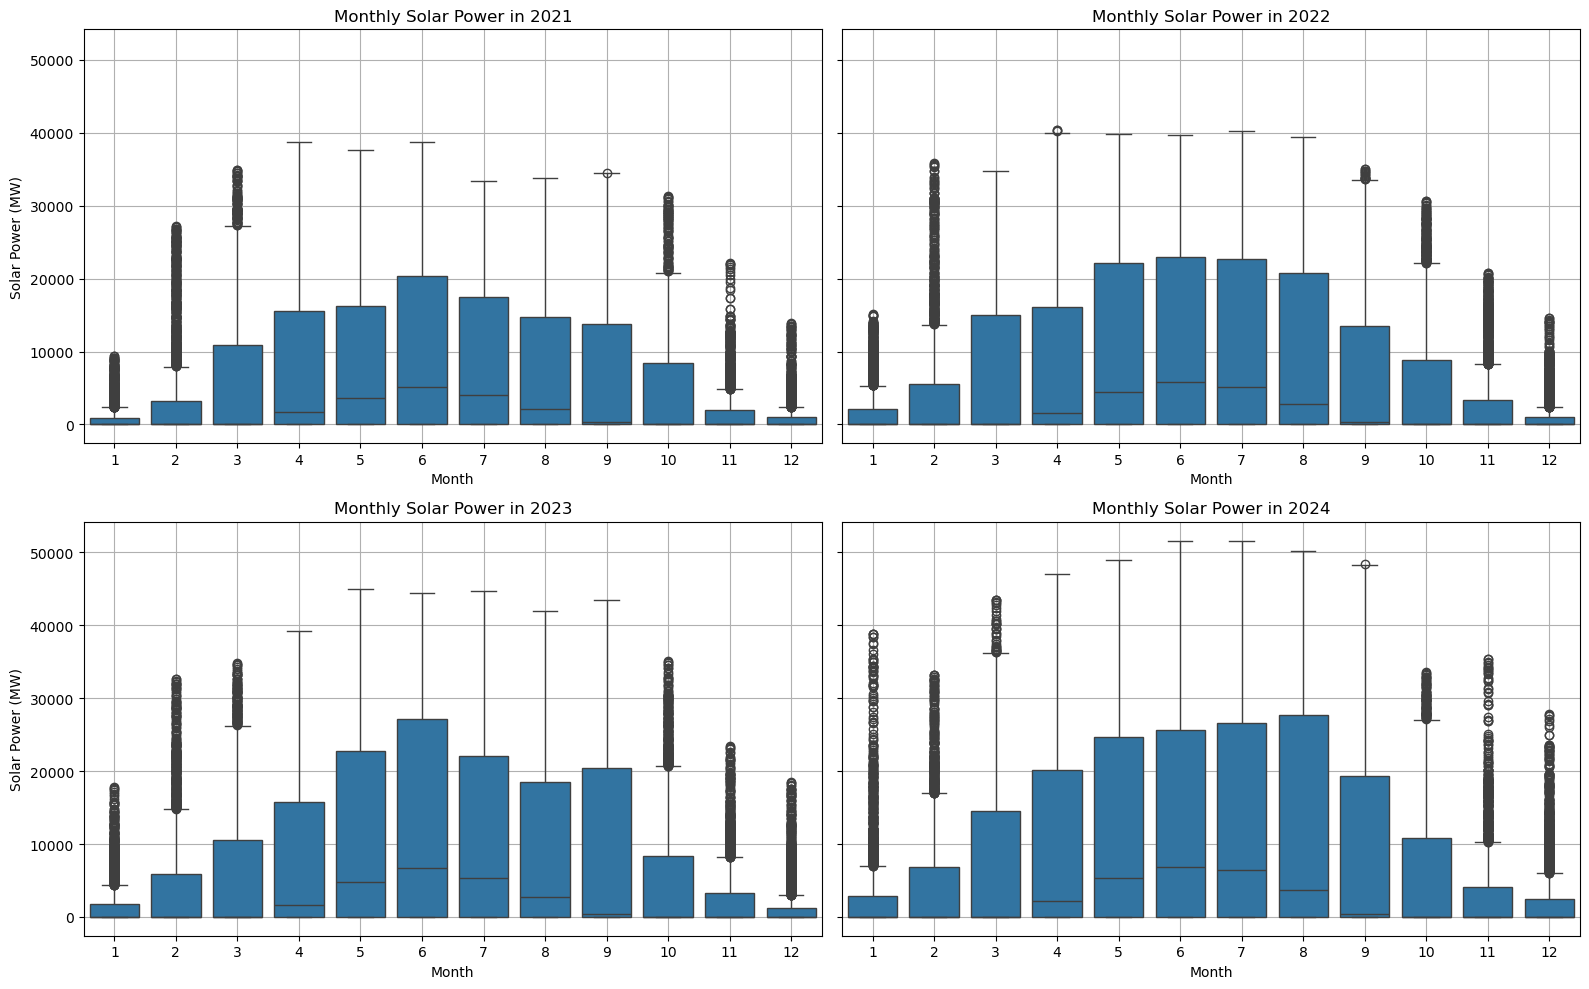

In [16]:
# Ensure index is datetime
df_solar.index = pd.to_datetime(df_solar.index)

# Define the years you want to plot
years = [2021, 2022, 2023, 2024]

# Create subplots: 2 rows, 2 columns
fig, axes = plt.subplots(2, 2, figsize=(16, 10), sharey=True)

# Flatten the axes array for easy iteration
axes = axes.flatten()

# Loop through years and axes
for i, year in enumerate(years):
    df_year = df_solar[df_solar.index.year == year]
    sns.boxplot(x=df_year.index.month, y=df_year['Solar-Power-MW'], ax=axes[i])
    axes[i].set_title(f"Monthly Solar Power in {year}")
    axes[i].set_xlabel("Month")
    axes[i].set_ylabel("Solar Power (MW)")
    axes[i].grid(True)

plt.tight_layout()
plt.show()

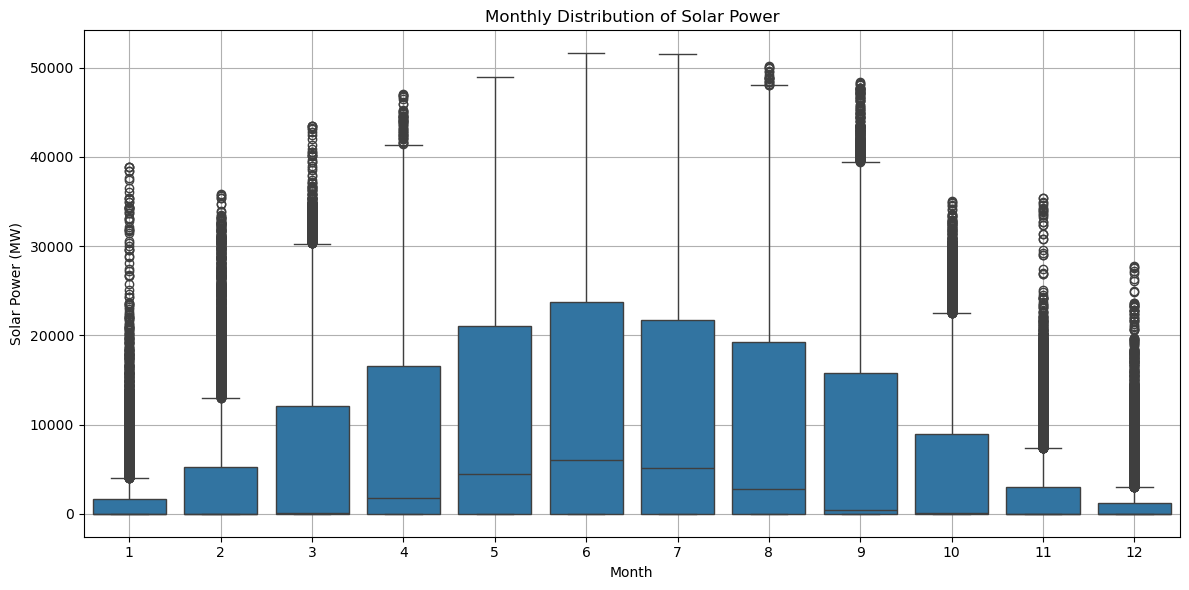

In [17]:
# Plot Monthly Distribution of Solar Power using the index's month
plt.figure(figsize=(12, 6))
sns.boxplot(x=df_solar.index.month, y=df_solar['Solar-Power-MW'])
plt.title("Monthly Distribution of Solar Power")
plt.xlabel("Month")
plt.ylabel("Solar Power (MW)")
plt.grid(True)
plt.tight_layout()
plt.show()

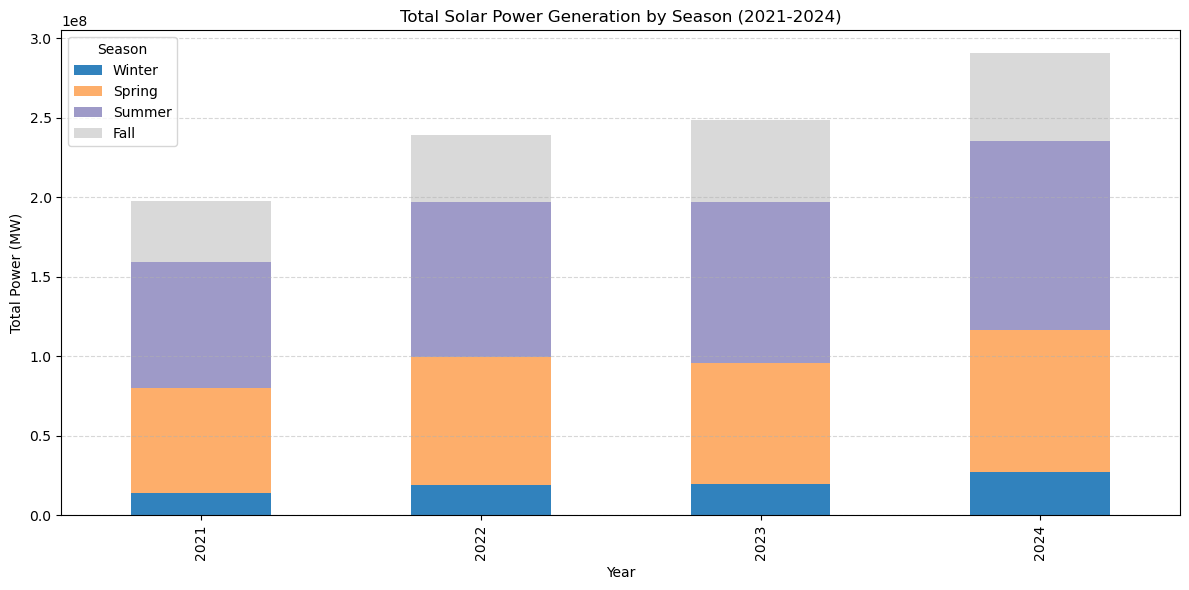

In [18]:
# Ensure datetime index
df_solar.index = pd.to_datetime(df_solar.index)

# Map months to seasons
def get_season(month):
    return {
        12: "Winter", 1: "Winter", 2: "Winter",
        3: "Spring", 4: "Spring", 5: "Spring",
        6: "Summer", 7: "Summer", 8: "Summer",
        9: "Fall",   10: "Fall",  11: "Fall"
    }[month]

# Add season and year columns
df_solar["season"] = df_solar.index.month.map(get_season)
df_solar["year"] = df_solar.index.year

# Group and sum solar power by year and season
seasonal_totals = df_solar.groupby(["year", "season"])["Solar-Power-MW"].sum().unstack(fill_value=0)

# Keep only 2021–2024
seasonal_totals = seasonal_totals.loc[[2021, 2022, 2023, 2024]]

# Sort columns to have consistent season order
season_order = ["Winter", "Spring", "Summer", "Fall"]
seasonal_totals = seasonal_totals[season_order]

# Plot stacked bar chart
seasonal_totals.plot(kind="bar", figsize=(12, 6), stacked=True, colormap="tab20c")
plt.title("Total Solar Power Generation by Season (2021-2024)")
plt.ylabel("Total Power (MW)")
plt.xlabel("Year")
plt.legend(title="Season")
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


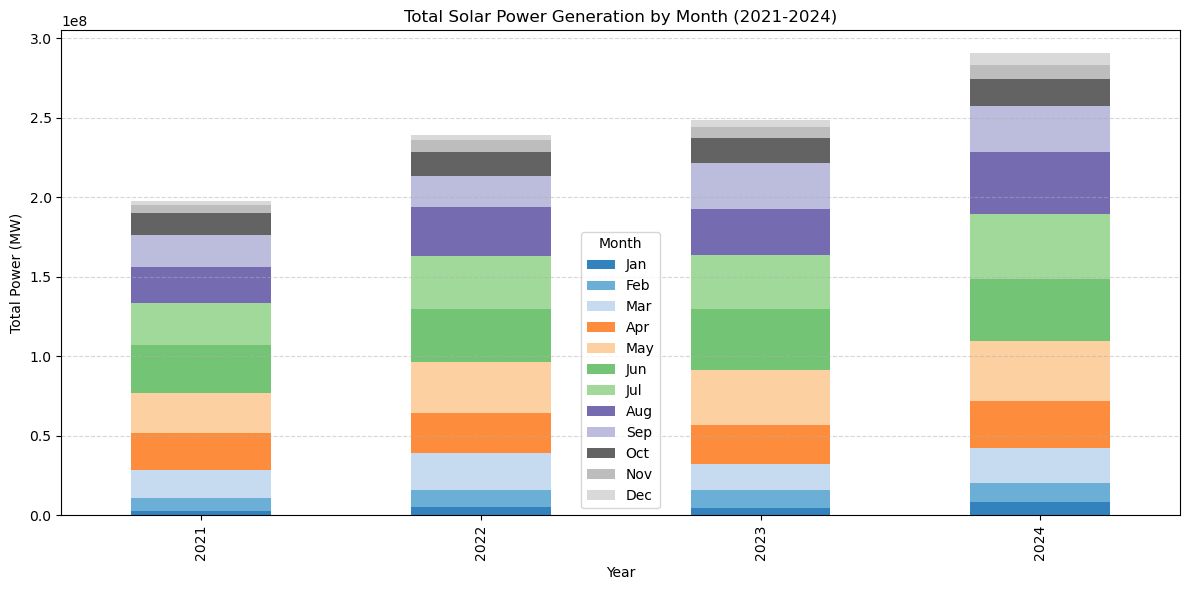

In [21]:
# Ensure datetime index
df_solar.index = pd.to_datetime(df_solar.index)

# Add month and year columns
df_solar["month"] = df_solar.index.month
df_solar["year"] = df_solar.index.year

# Group and sum solar power by year and month
monthly_totals = df_solar.groupby(["year", "month"])["Solar-Power-MW"].sum().unstack(fill_value=0)

# Keep only 2021–2024
monthly_totals = monthly_totals.loc[[2021, 2022, 2023, 2024]]

# Plot stacked bar chart
monthly_totals.plot(kind="bar", figsize=(12, 6), stacked=True, colormap="tab20c")
plt.title("Total Solar Power Generation by Month (2021-2024)")
plt.ylabel("Total Power (MW)")
plt.xlabel("Year")
plt.legend(title="Month", labels=[
    "Jan", "Feb", "Mar", "Apr", "May", "Jun", 
    "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"])
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


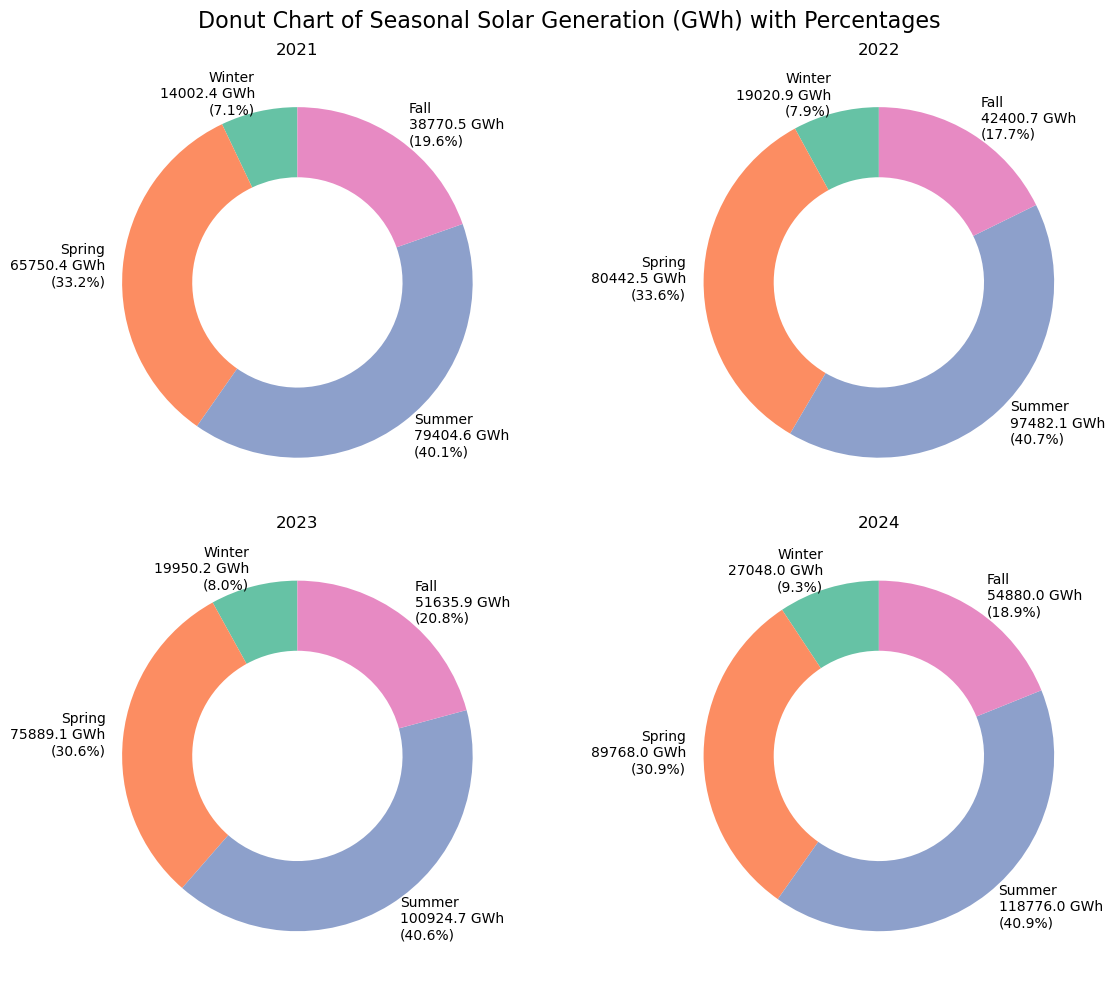

In [22]:
# Ensure datetime index
df_solar.index = pd.to_datetime(df_solar.index)

# Map months to seasons
def get_season(month):
    return {
        12: "Winter", 1: "Winter", 2: "Winter",
        3: "Spring", 4: "Spring", 5: "Spring",
        6: "Summer", 7: "Summer", 8: "Summer",
        9: "Fall",   10: "Fall",  11: "Fall"
    }[month]

# Add season and year columns
df_solar["season"] = df_solar.index.month.map(get_season)
df_solar["year"] = df_solar.index.year

# Group and sum by year and season
seasonal_totals = df_solar.groupby(["year", "season"])["Solar-Power-MW"].sum().unstack(fill_value=0)

# Keep only 2021–2024
seasonal_totals = seasonal_totals.loc[[2021, 2022, 2023, 2024]]

# Sort columns by season
season_order = ["Winter", "Spring", "Summer", "Fall"]
seasonal_totals = seasonal_totals[season_order]

# Plot donut charts in 2x2 grid
fig, axs = plt.subplots(2, 2, figsize=(12, 10))
colors = ['#66c2a5', '#fc8d62', '#8da0cb', '#e78ac3']
axs = axs.flatten()  # Flatten for easy indexing

for i, year in enumerate(seasonal_totals.index):
    values = seasonal_totals.loc[year]
    total = values.sum()  # Total generation for the year

    # Create labels with both GWh and percentage
    labels = [
        f"{season}\n{value/1e3:.1f} GWh\n({value/total*100:.1f}%)"
        for season, value in values.items()
    ]

    axs[i].pie(
        values,
        labels=labels,
        colors=colors,
        startangle=90,
        wedgeprops={'width': 0.4}
    )
    axs[i].set_title(f"{year}")

plt.suptitle("Donut Chart of Seasonal Solar Generation (GWh) with Percentages", fontsize=16)
plt.tight_layout()
plt.show()


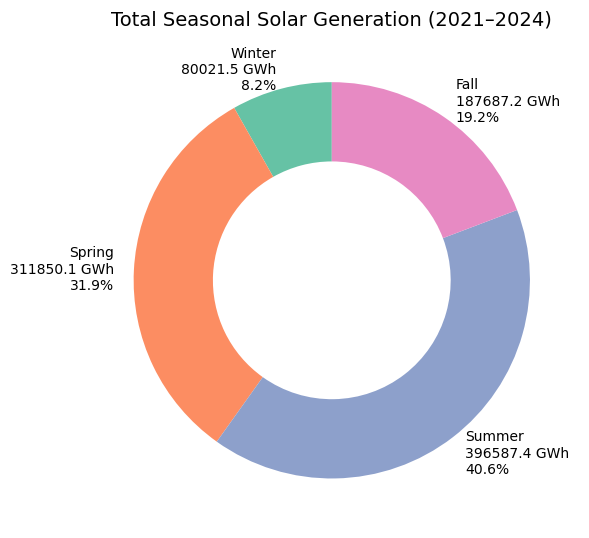

In [23]:
# Sum all years (2021–2024) by season
total_by_season = seasonal_totals.sum(axis=0)

# Compute total sum to calculate percentages
total_sum = total_by_season.sum()

# Format labels with GWh and percentage
labels = [
    f"{season}\n{value/1e3:.1f} GWh\n{value/total_sum*100:.1f}%"
    for season, value in total_by_season.items()
]

# Plot the donut chart
fig, ax = plt.subplots(figsize=(6, 6))

ax.pie(
    total_by_season,
    labels=labels,
    colors=colors,
    startangle=90,
    wedgeprops={'width': 0.4}
)

ax.set_title("Total Seasonal Solar Generation (2021–2024)", fontsize=14)
plt.tight_layout()
plt.show()


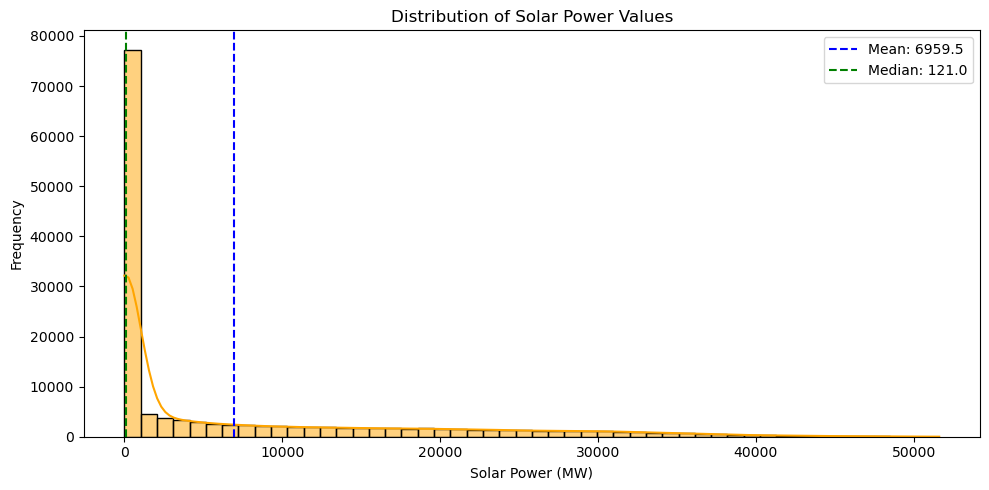

In [24]:
plt.figure(figsize=(10, 5))
sns.histplot(df_solar['Solar-Power-MW'], bins=50, kde=True, color='orange')
plt.title("Distribution of Solar Power Values")
plt.xlabel("Solar Power (MW)")
plt.ylabel("Frequency")
plt.axvline(df_solar['Solar-Power-MW'].mean(), color='blue', linestyle='--', label=f"Mean: {df_solar['Solar-Power-MW'].mean():.1f}")
plt.axvline(df_solar['Solar-Power-MW'].median(), color='green', linestyle='--', label=f"Median: {df_solar['Solar-Power-MW'].median():.1f}")
plt.legend()
plt.tight_layout()
plt.show()


In [25]:
# Ensure index is datetime
df_solar.index = pd.to_datetime(df_solar.index)

# Define the years
years = [2021, 2022, 2023, 2024]

# Dictionary to hold stats
yearly_stats = {}

# Loop through each year and compute describe
for year in years:
    df_year = df_solar[df_solar.index.year == year]
    stats = df_year['Solar-Power-MW'].describe()
    yearly_stats[year] = stats

# Display results
for year, stats in yearly_stats.items():
    print(f"\nStatistical Summary for {year}:")
    print(stats)



Statistical Summary for 2021:
count    35040.000000
mean      5648.630100
std       8741.721706
min          0.000000
25%          0.000000
50%        112.200000
75%       9232.475000
max      38770.900000
Name: Solar-Power-MW, dtype: float64

Statistical Summary for 2022:
count    35040.000000
mean      6830.657209
std      10308.536619
min          0.000000
25%          0.000000
50%        110.050000
75%      11337.125000
max      40368.600000
Name: Solar-Power-MW, dtype: float64

Statistical Summary for 2023:
count    35040.000000
mean      7089.041047
std      10857.375718
min          0.000000
25%          0.000000
50%        115.150000
75%      11329.800000
max      45036.600000
Name: Solar-Power-MW, dtype: float64

Statistical Summary for 2024:
count    35136.000000
mean      8267.076531
std      12334.219564
min          0.000000
25%          0.000000
50%        153.700000
75%      13960.775000
max      51607.900000
Name: Solar-Power-MW, dtype: float64


In [26]:
# Basic statistical summary
stats = df_solar['Solar-Power-MW'].describe()
print(stats)

count    140260.000000
mean       6959.548172
std       10680.034551
min           0.000000
25%           0.000000
50%         121.000000
75%       11364.875000
max       51607.900000
Name: Solar-Power-MW, dtype: float64


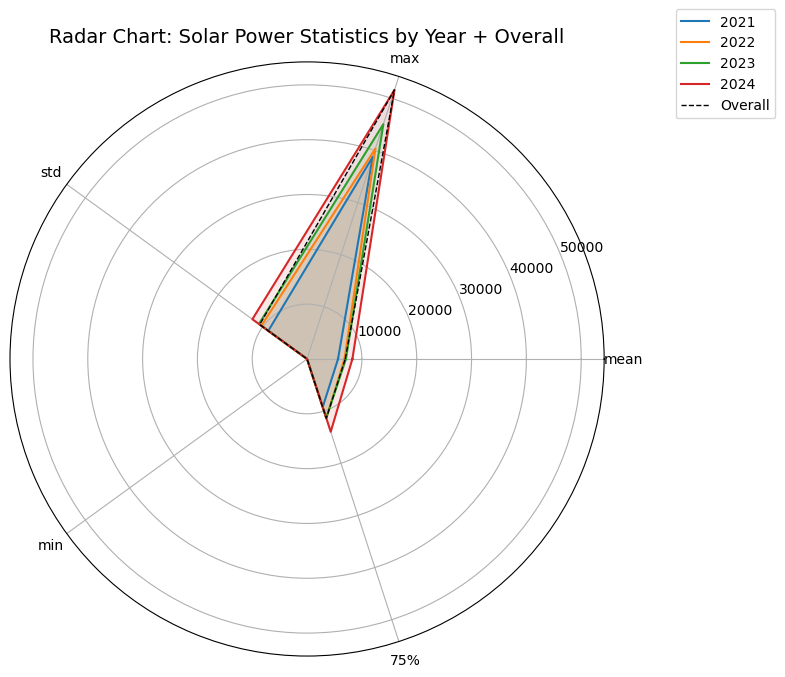

In [27]:
# Ensure index is datetime
df_solar.index = pd.to_datetime(df_solar.index)

# Define years
years = [2021, 2022, 2023, 2024]

# Compute per-year statistics
summary_df = pd.DataFrame()
for year in years:
    df_year = df_solar[df_solar.index.year == year]
    stats = df_year['Solar-Power-MW'].describe()
    summary_df[year] = stats

summary_df = summary_df.T

# Select stats to compare
columns_to_plot = ['mean', 'max', 'std', 'min', '75%']

# Radar chart setup
labels = columns_to_plot
num_vars = len(labels)
angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()
angles += angles[:1]  # close the loop

# Initialize plot
fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(polar=True))

# Plot each year's stats
for year in years:
    values = summary_df.loc[year, labels].tolist()
    values += values[:1]
    ax.plot(angles, values, label=str(year))
    ax.fill(angles, values, alpha=0.1)

# Add overall stats
overall_stats = df_solar['Solar-Power-MW'].describe()
overall_values = overall_stats[labels].tolist()
overall_values += overall_values[:1]
ax.plot(angles, overall_values, label='Overall', linestyle='--', linewidth=1, color='black')
ax.fill(angles, overall_values, alpha=0.1, color='gray')

# Final plot settings
ax.set_xticks(angles[:-1])
ax.set_xticklabels(labels)
ax.set_title("Radar Chart: Solar Power Statistics by Year + Overall", size=14)
ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1))
plt.tight_layout()
plt.show()

In [26]:
#first idea remove daily trend from ts then run decomposition

In [29]:

# Step 1: Calculate the daily profile by averaging over each 15-minute interval (same time every day)
df_solar['time'] = df_solar.index.time  # Extract time from the DateTimeIndex
daily_profile = df_solar.groupby('time')['Solar-Power-MW'].mean()  # Average power at each 15-minute interval

# Step 2: Remove the daily profile from the original time series
df_solar['daily_profile'] = df_solar['time'].map(daily_profile)
df_solar['removed_dialy_profile'] = df_solar['Solar-Power-MW'] - df_solar['daily_profile']


In [30]:
def plot_solar_components(df_solar, date_str):

    # Filter for the selected date
    daily_data = df_solar.loc[date_str]

    # Plot
    plt.figure(figsize=(15, 5))
    plt.plot(daily_data.index, daily_data['Solar-Power-MW'], label='Actual Solar Power (MW)', color='blue')
    plt.plot(daily_data.index, daily_data['daily_profile'], label='Daily Profile', color='green')
    plt.plot(daily_data.index, daily_data['removed_dialy_profile'], label='Removed Daily Profile', color='orange', linestyle='--')

    plt.title(f'Solar Generation Components for {date_str}')
    plt.xlabel('Time')
    plt.ylabel('Power (MW)')
    plt.xticks(rotation=45)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


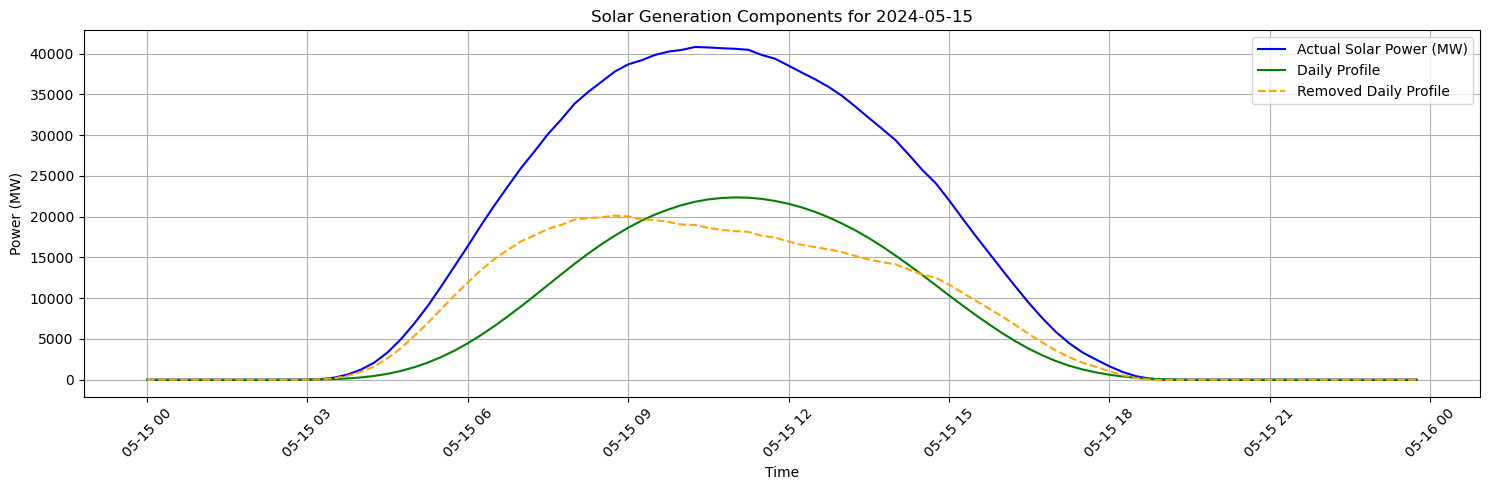

In [31]:
plot_solar_components(df_solar, '2024-05-15')


# Phase 1: Seasonal decomposition

Seasonal decomposition applied on the residual series. 

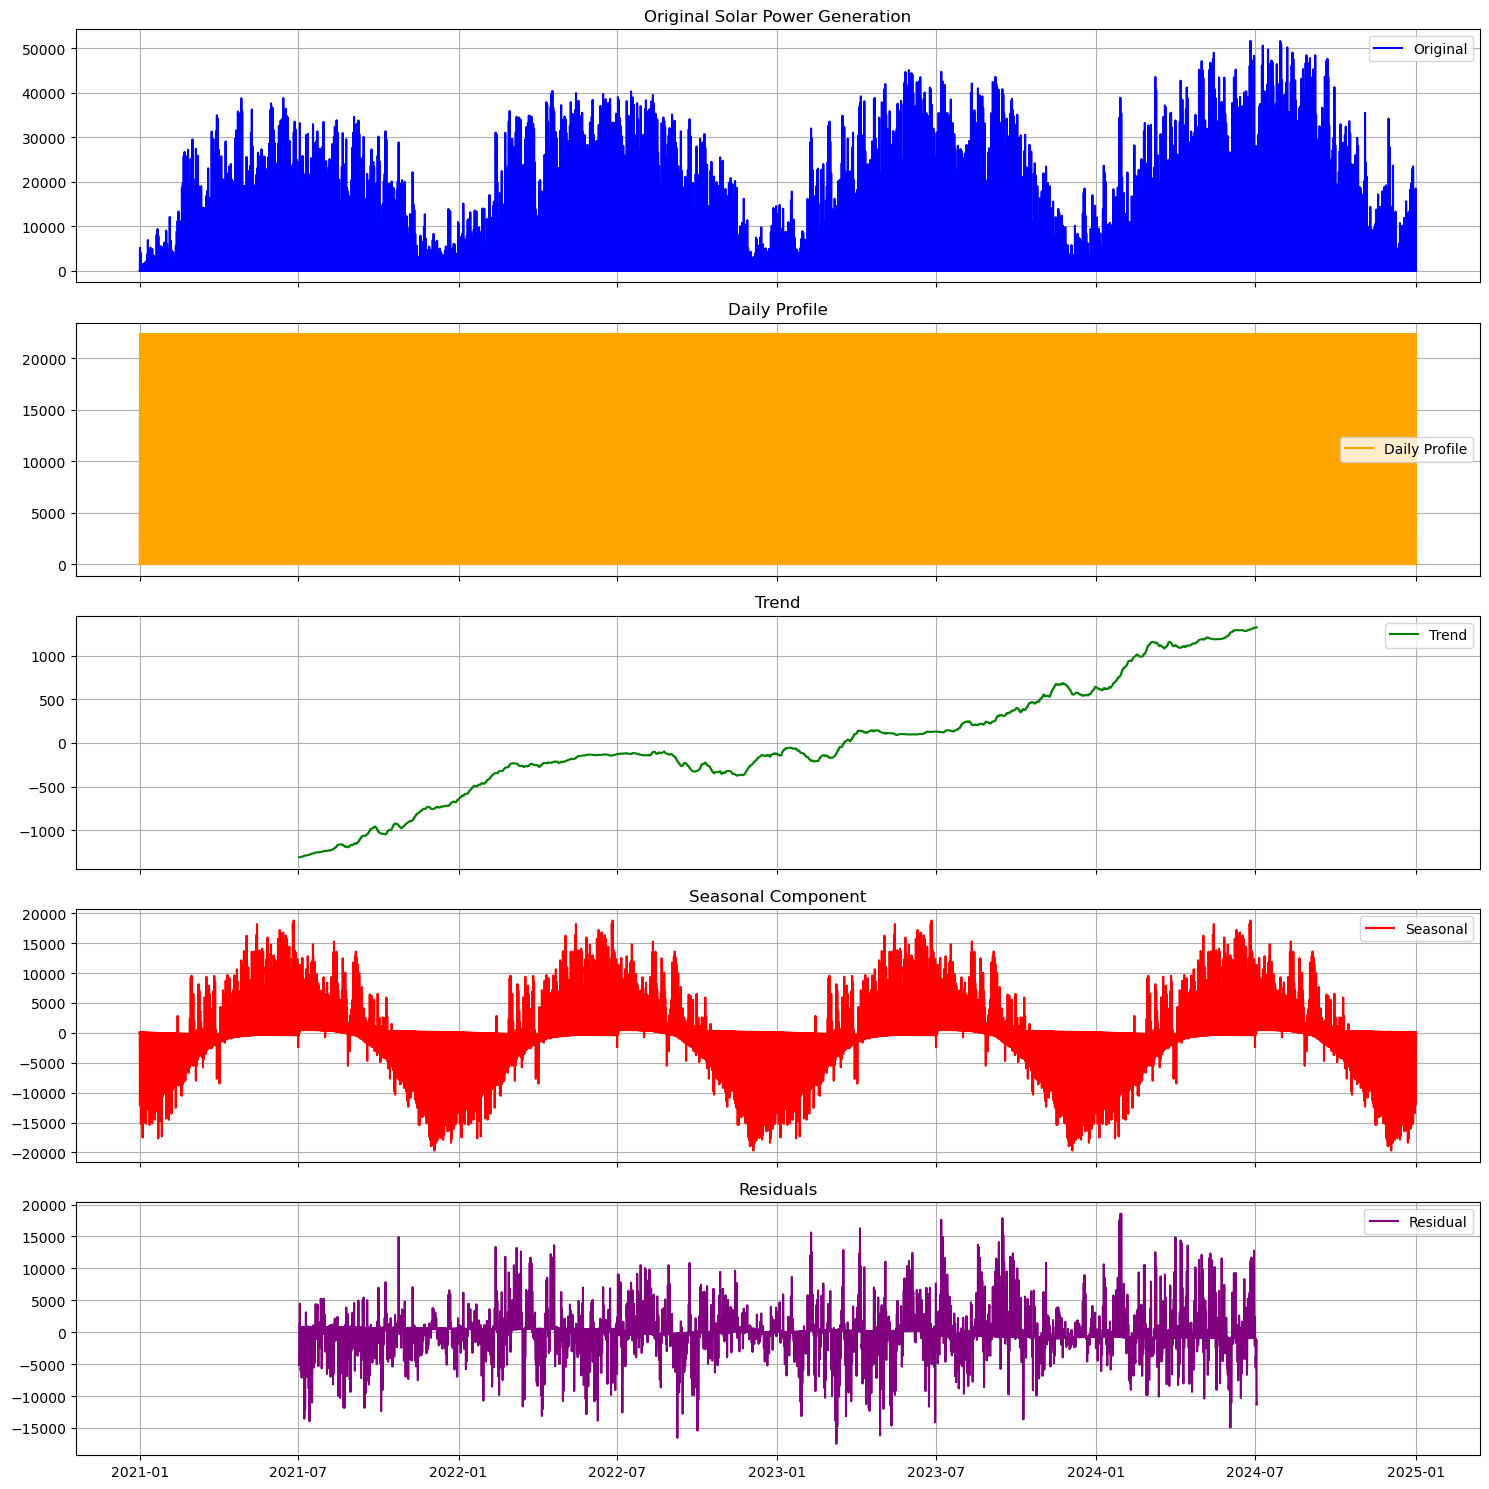

In [32]:
# Step 3: Applying seasonal decomposition on the residual series
# As we're using 15-minute intervals, we set the period to 96 (15-minute data points per hour * 24 hours)
residual_series = df_solar['removed_dialy_profile']
result = sm.tsa.seasonal_decompose(residual_series, period=96*365, model='additive')

# Step 4: Extracting the components (trend, seasonal, residuals) from the decomposition
trend = result.trend
seasonal = result.seasonal
residual = result.resid

# Step 5: Ploting the components
fig, axs = plt.subplots(5, 1, figsize=(15, 15), sharex=True)

# Ploting the original series
axs[0].plot(df_solar.index, df_solar['Solar-Power-MW'], label='Original', color='blue')
axs[0].set_title('Original Solar Power Generation')

# Ploting the daily profile
axs[1].plot(df_solar.index, df_solar['daily_profile'], label='Daily Profile', color='orange')
axs[1].set_title('Daily Profile')

# Ploting the trend component from seasonal_decompose
axs[2].plot(df_solar.index, trend, label='Trend', color='green')
axs[2].set_title('Trend')

# Ploting the seasonal component from seasonal_decompose
axs[3].plot(df_solar.index, seasonal, label='Seasonal', color='red')
axs[3].set_title('Seasonal Component')

# Ploting the residual component from seasonal_decompose
axs[4].plot(df_solar.index, residual, label='Residual', color='purple')
axs[4].set_title('Residuals')

# Add labels and grid to all plots
for ax in axs:
    ax.legend()
    ax.grid(True)

plt.tight_layout()
plt.show()


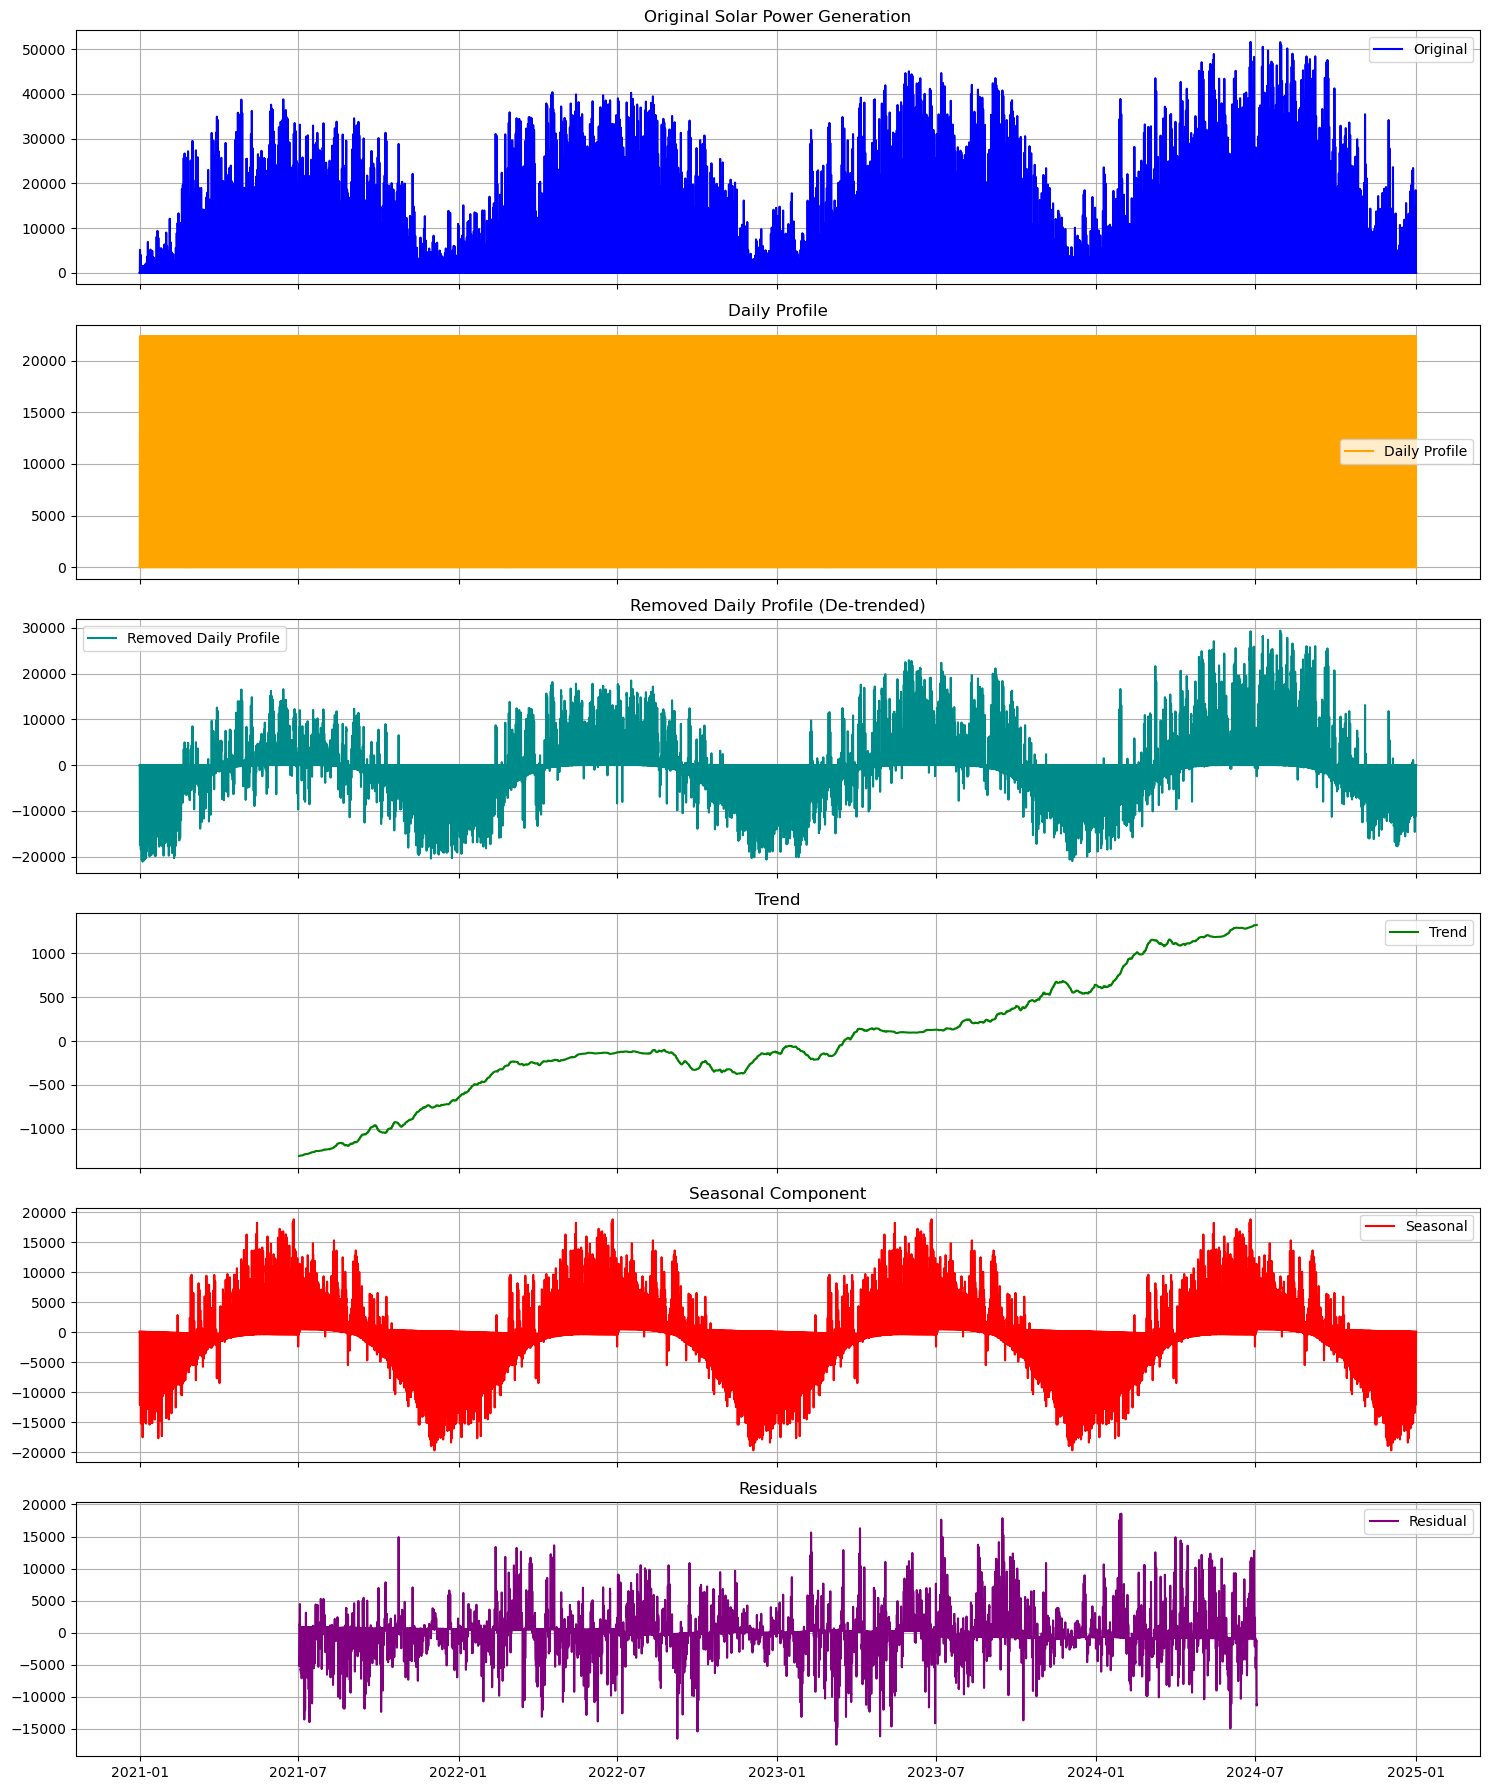

In [33]:
# Step 5: Plot the components
fig, axs = plt.subplots(6, 1, figsize=(15, 18), sharex=True)  # Note: changed to 6 plots

# Plot the original series
axs[0].plot(df_solar.index, df_solar['Solar-Power-MW'], label='Original', color='blue')
axs[0].set_title('Original Solar Power Generation')

# Plot the daily profile
axs[1].plot(df_solar.index, df_solar['daily_profile'], label='Daily Profile', color='orange')
axs[1].set_title('Daily Profile')

# Plot the removed daily profile
axs[2].plot(df_solar.index, df_solar['removed_dialy_profile'], label='Removed Daily Profile', color='darkcyan')
axs[2].set_title('Removed Daily Profile (De-trended)')

# Plot the trend component from seasonal_decompose
axs[3].plot(df_solar.index, trend, label='Trend', color='green')
axs[3].set_title('Trend')

# Plot the seasonal component from seasonal_decompose
axs[4].plot(df_solar.index, seasonal, label='Seasonal', color='red')
axs[4].set_title('Seasonal Component')

# Plot the residual component from seasonal_decompose
axs[5].plot(df_solar.index, residual, label='Residual', color='purple')
axs[5].set_title('Residuals')

# Add labels and grid to all plots
for ax in axs:
    ax.legend()
    ax.grid(True)

plt.tight_layout()
plt.show()


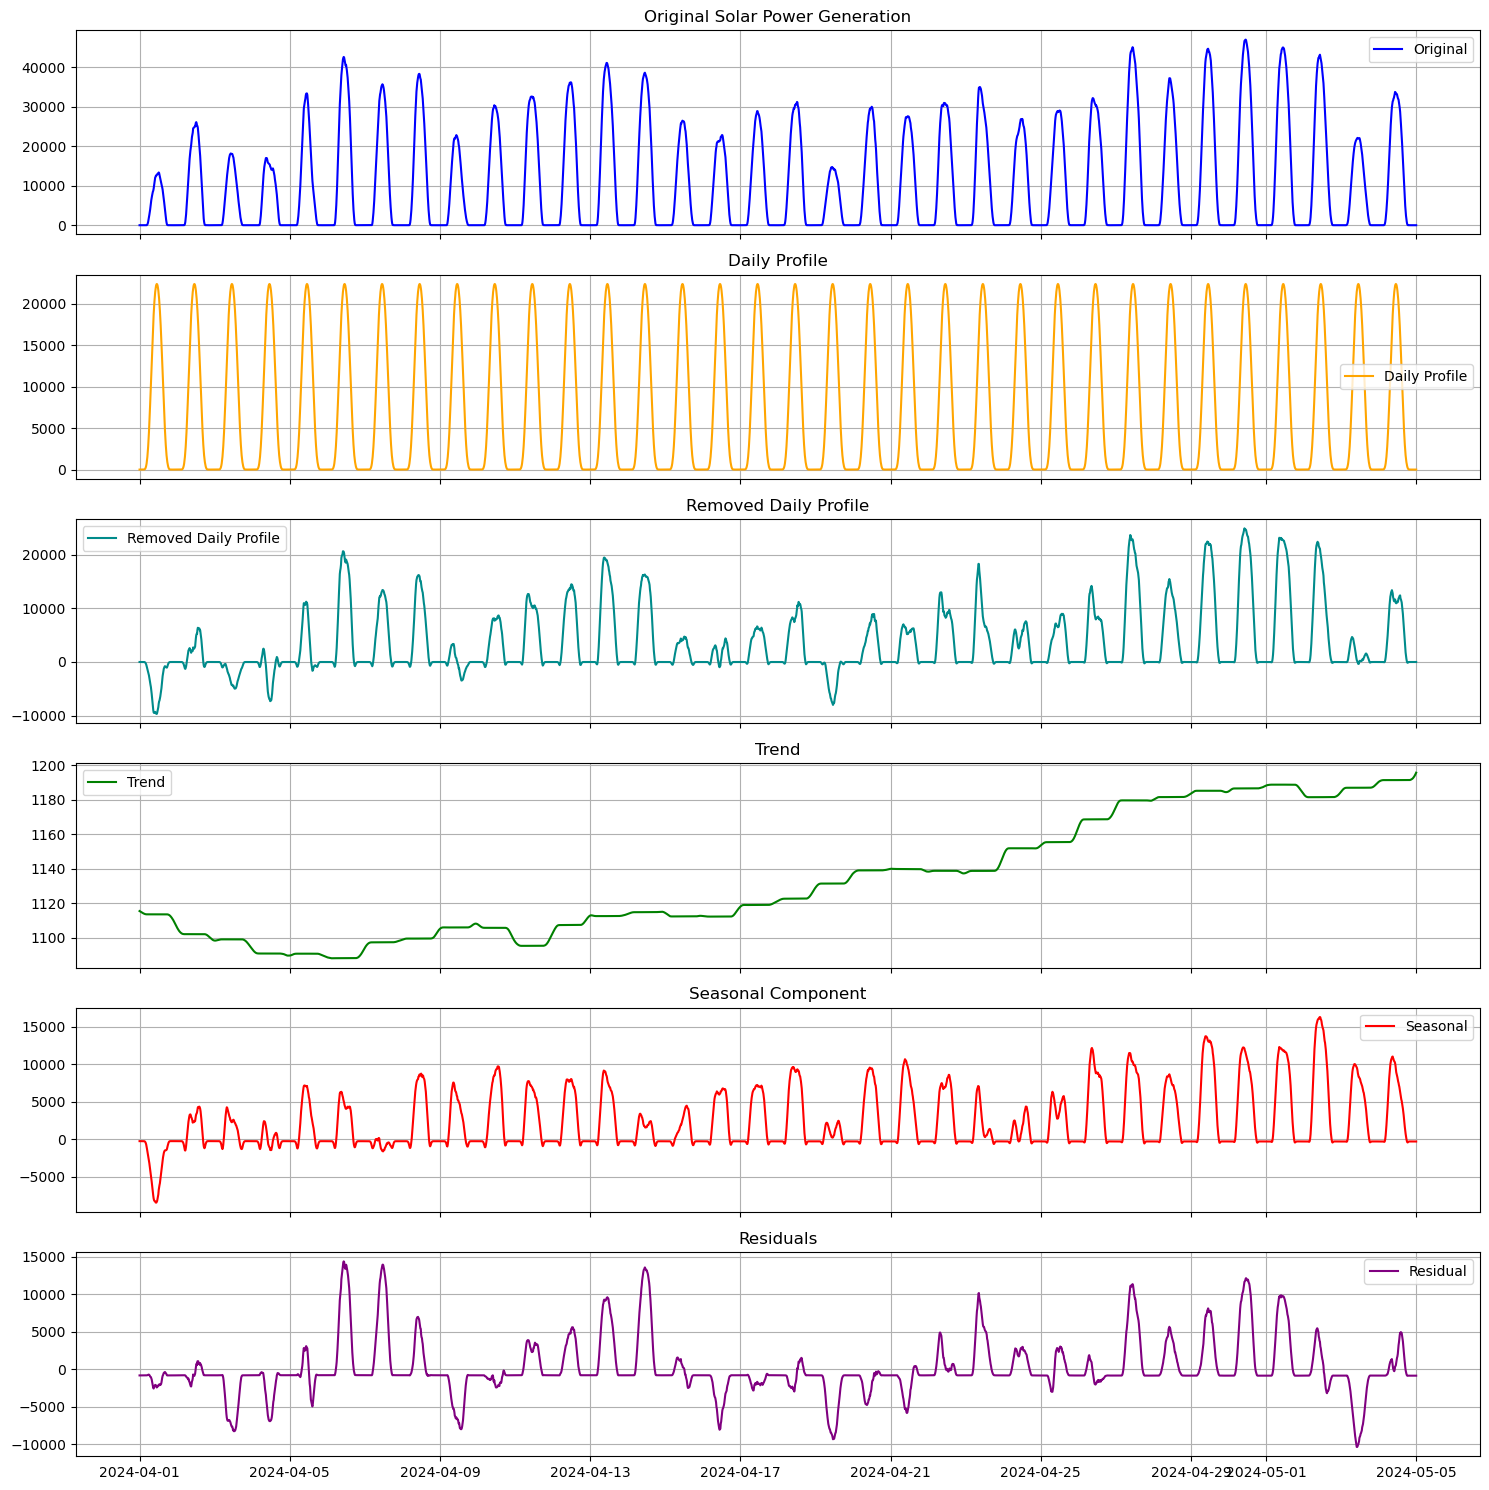

In [34]:
# Define the time range you want to zoom into (for example, from June 1, 2022 to June 2, 2022)
start_time = pd.to_datetime('2024-04-01 00:00:00')
end_time = pd.to_datetime('2024-05-05 00:00:00')

# Filter the data to show only the desired time range
df_zoomed = df_solar[(df_solar.index >= start_time) & (df_solar.index <= end_time)]
trend_zoomed = trend[(df_solar.index >= start_time) & (df_solar.index <= end_time)]
seasonal_zoomed = seasonal[(df_solar.index >= start_time) & (df_solar.index <= end_time)]
residual_zoomed = residual[(df_solar.index >= start_time) & (df_solar.index <= end_time)]

# Step 5: Plot the components for the zoomed time range
fig, axs = plt.subplots(6, 1, figsize=(15, 15), sharex=True)

# Plot the original series
axs[0].plot(df_zoomed.index, df_zoomed['Solar-Power-MW'], label='Original', color='blue')
axs[0].set_title('Original Solar Power Generation')

# Plot the daily profile
axs[1].plot(df_zoomed.index, df_zoomed['daily_profile'], label='Daily Profile', color='orange')
axs[1].set_title('Daily Profile')

# Plot the removed daily profile
axs[2].plot(df_zoomed.index, df_zoomed['removed_dialy_profile'], label='Removed Daily Profile', color='darkcyan')
axs[2].set_title('Removed Daily Profile')

# Plot the trend component from seasonal_decompose
axs[3].plot(df_zoomed.index, trend_zoomed, label='Trend', color='green')
axs[3].set_title('Trend')

# Plot the seasonal component from seasonal_decompose
axs[4].plot(df_zoomed.index, seasonal_zoomed, label='Seasonal', color='red')
axs[4].set_title('Seasonal Component')

# Plot the residual component from seasonal_decompose
axs[5].plot(df_zoomed.index, residual_zoomed, label='Residual', color='purple')
axs[5].set_title('Residuals')

# Add labels and grid to all plots
for ax in axs:
    ax.legend()
    ax.grid(True)

plt.tight_layout()
plt.show()


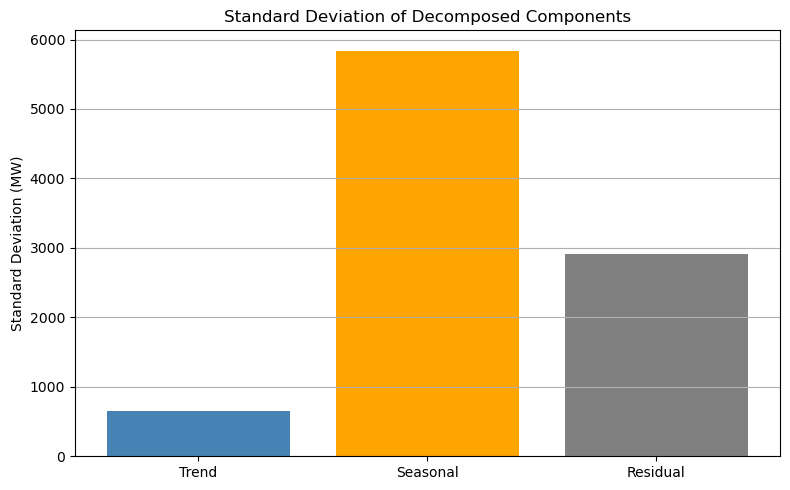

In [35]:
components = ['Trend', 'Seasonal', 'Residual']
stds = [trend.std(), seasonal.std(), residual.std()]

plt.figure(figsize=(8, 5))
plt.bar(components, stds, color=['steelblue', 'orange', 'gray'])
plt.title('Standard Deviation of Decomposed Components')
plt.ylabel('Standard Deviation (MW)')
plt.grid(True, axis='y')
plt.tight_layout()
plt.show()

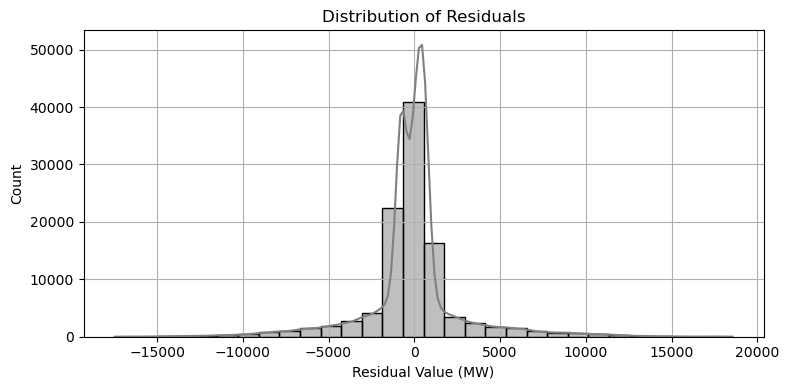

Residual Mean: -42.04304960633642
Residual std: 2919.0132377156315
Residual Skewness: 0.2683833666850075
Residual Kurtosis: 6.3338435086884095


In [36]:
plt.figure(figsize=(8, 4))
sns.histplot(residual, kde=True, bins=30, color='gray')
plt.title("Distribution of Residuals")
plt.xlabel("Residual Value (MW)")
plt.grid(True)
plt.tight_layout()
plt.show()

print("Residual Mean:", residual.mean())
print("Residual std:", residual.std())
print("Residual Skewness:", residual.skew())
print("Residual Kurtosis:", residual.kurtosis())

<Figure size 800x400 with 0 Axes>

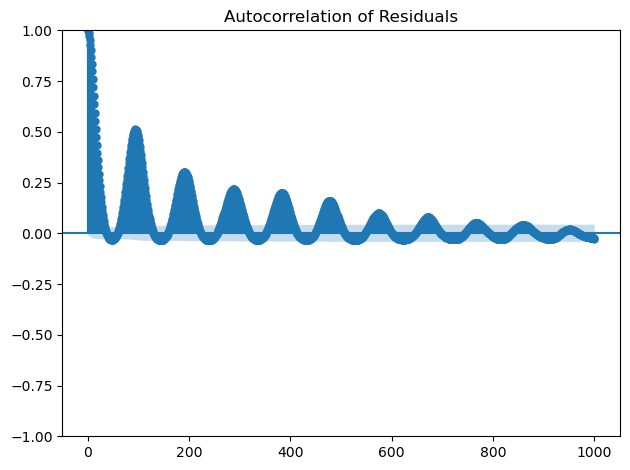

In [37]:
from statsmodels.graphics.tsaplots import plot_acf
# Drop NaNs from residuals
residual_clean = residual.dropna()

# Plot ACF
plt.figure(figsize=(8, 4))
plot_acf(residual_clean, lags=1000)
plt.title("Autocorrelation of Residuals")
plt.tight_layout()
plt.show()


✅ Steps to Recompose the Series

    Recompose by:
    Synthetic Series=Trend+Seasonal+Daily Profile+Synthetic Residuals


## Recompose the time series
Recomposed by: 
Synthetic Series = Trend + Seasonal + Daily Profile + Synthetic Residuals 

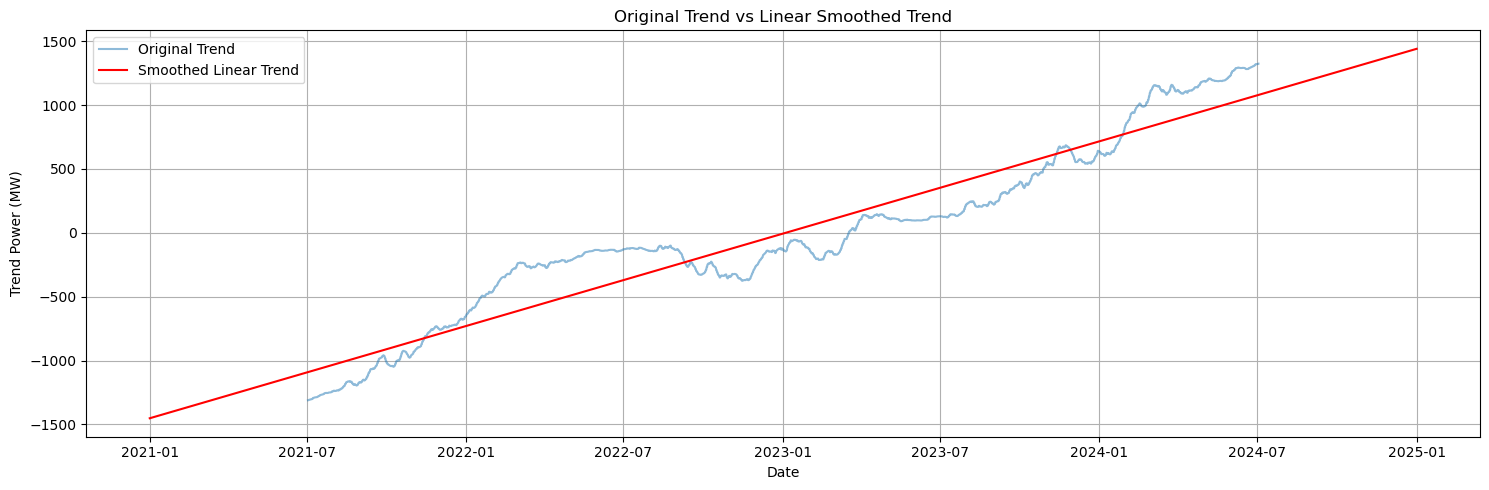

In [45]:
from sklearn.linear_model import LinearRegression


# Step 1: Prepare the data (drop NaN values from the trend component)
df_solar['trend_decomp'] = result.trend  # Assuming 'result' is your seasonal decomposition result

# Drop NaN values from the trend component for linear regression
df_trend = df_solar[['trend_decomp']].dropna().copy()

# Calculate time in minutes from the first data point (for the independent variable)
df_trend['time_num'] = (df_trend.index - df_trend.index[0]).total_seconds() / 60  # in minutes

# Step 2: Fit linear regression
X = df_trend[['time_num']]  # Independent variable: time in minutes
y = df_trend['trend_decomp']  # Dependent variable: trend values from decomposition
model = LinearRegression().fit(X, y)  # Fit the model

# Step 3: Predict the linear trend over the entire time range
df_solar['time_num'] = (df_solar.index - df_trend.index[0]).total_seconds() / 60  # Recalculate time for the full dataset
df_solar['linear_trend'] = model.predict(df_solar[['time_num']])  # Predict trend using linear regression

# Step 4: Plot the results
plt.figure(figsize=(15, 5))

# Plot the original trend component and the smoothed linear trend
plt.plot(df_solar.index, df_solar['trend_decomp'], label='Original Trend', alpha=0.5)
plt.plot(df_solar.index, df_solar['linear_trend_decomp'], label='Smoothed Linear Trend', color='red')

# Add labels, grid, and title
plt.legend()
plt.grid(True)
plt.title('Original Trend vs Linear Smoothed Trend')
plt.xlabel('Date')
plt.ylabel('Trend Power (MW)')

# Show the plot
plt.tight_layout()
plt.show()


In [46]:
# Ensure everything is aligned
df_solar['trend'] = result.trend
df_solar['seasonal'] = result.seasonal
df_solar['residual'] = result.resid

# Estimate daily profile again (as before)
df_solar['time'] = df_solar.index.time
daily_profile = df_solar.groupby('time')['Solar-Power-MW'].median()
df_solar['daily_profile'] = df_solar['time'].map(daily_profile)

In [47]:
# Estimate residual stats
resid_mean = df_solar['residual'].mean()
resid_std = df_solar['residual'].std()

# Simulate new noise
np.random.seed(42)  # for reproducibility
synthetic_residual = np.random.normal(loc=resid_mean, scale=resid_std, size=len(df_solar))

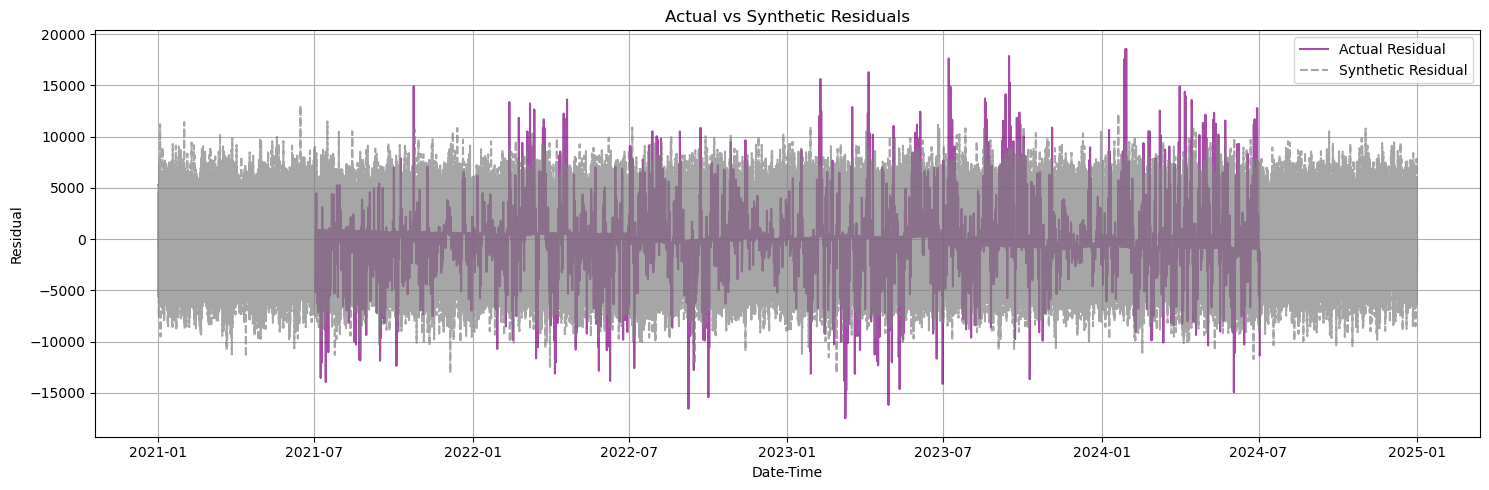

In [48]:
# Plot actual vs synthetic residuals
plt.figure(figsize=(15, 5))
plt.plot(df_solar.index, df_solar['residual'], label='Actual Residual', color='purple', alpha=0.7)
plt.plot(df_solar.index, synthetic_residual, label='Synthetic Residual', color='grey', linestyle='--', alpha=0.7)

plt.title("Actual vs Synthetic Residuals")
plt.xlabel("Date-Time")
plt.ylabel("Residual")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


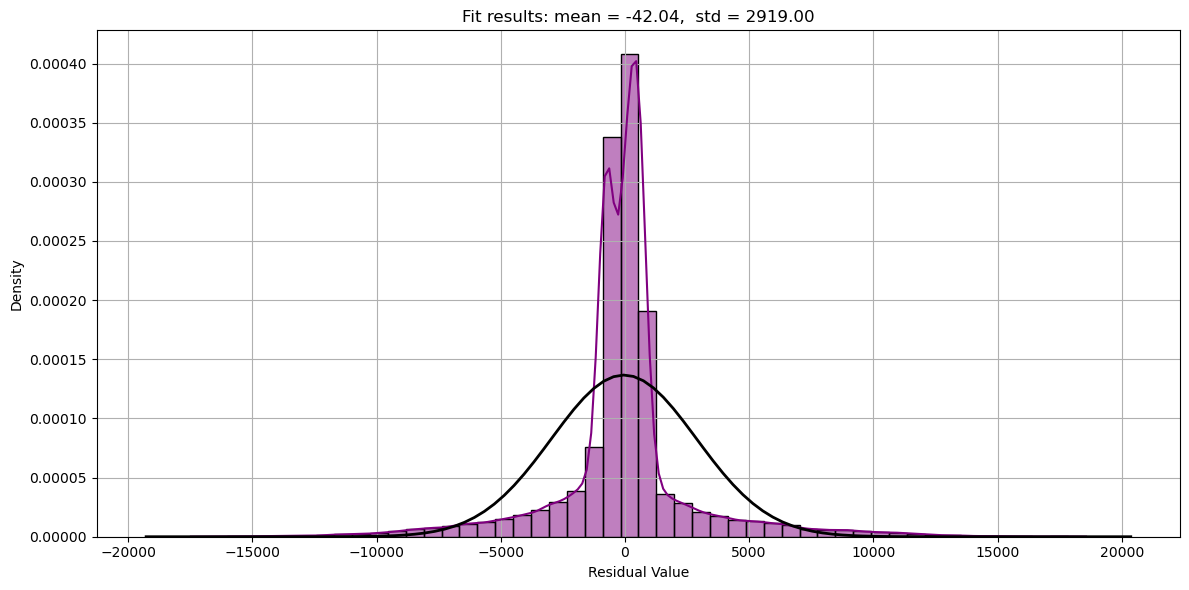

In [49]:
from scipy.stats import norm

# Fit a normal distribution to the residuals
mu, std = norm.fit(df_solar['residual'].dropna())

# Plot the histogram and the fitted normal distribution
plt.figure(figsize=(12, 6))
sns.histplot(df_solar['residual'], kde=True, color='purple', bins=50, stat='density')
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu, std)
plt.plot(x, p, 'k', linewidth=2)
title = "Fit results: mean = %.2f,  std = %.2f" % (mu, std)
plt.title(title)
plt.xlabel('Residual Value')
plt.ylabel('Density')
plt.grid(True)
plt.tight_layout()
plt.show()


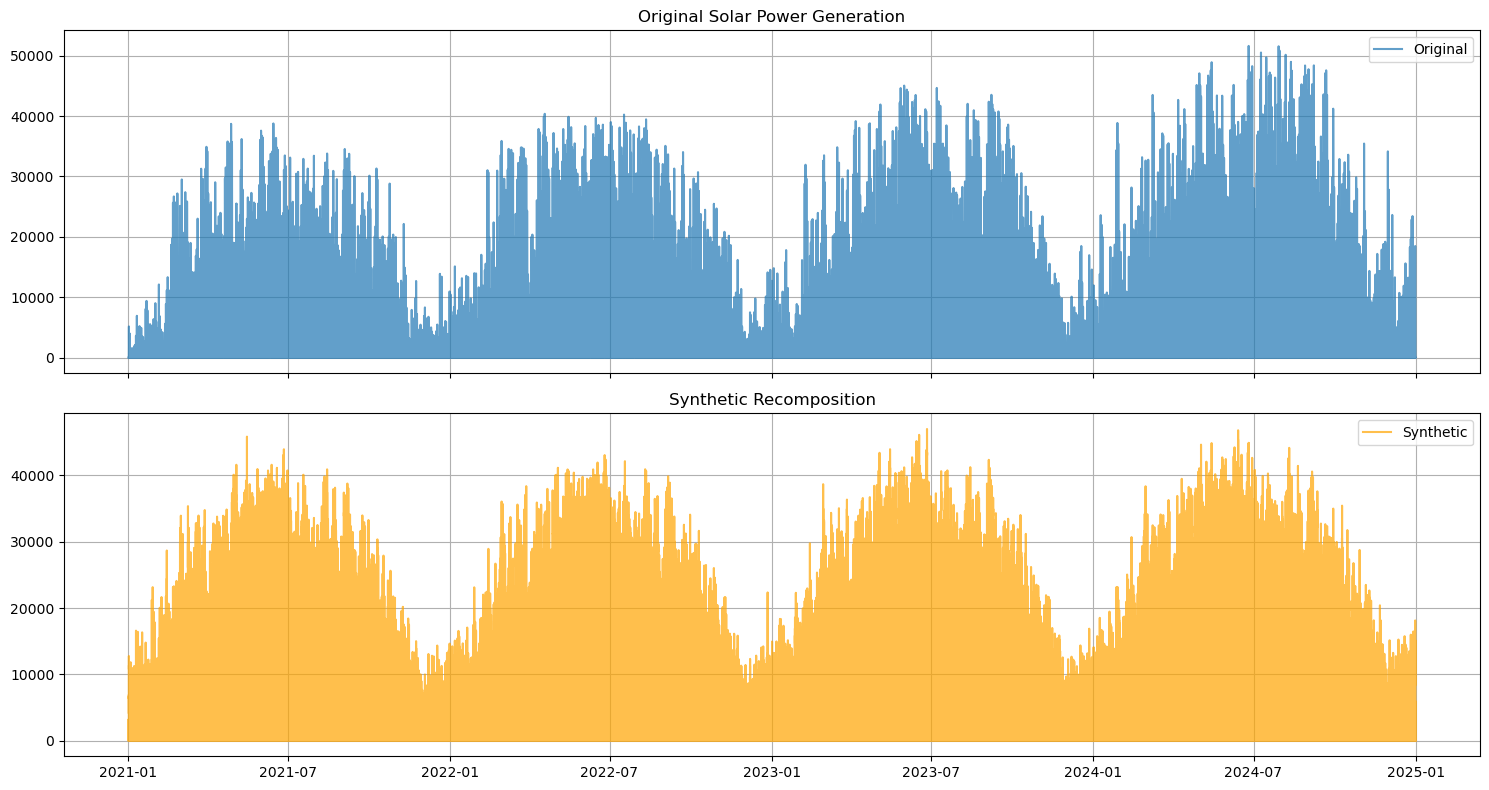

In [50]:
# Build the synthetic time series
df_solar['synthetic'] = (
    df_solar['linear_trend'].fillna(0) +
    #df_solar['polynomial_trend'].fillna(0) + 
    df_solar['seasonal'].fillna(0) +
    df_solar['daily_profile'].fillna(0) +
    synthetic_residual
)

#clip the recomposed series to avoid negatives:
df_solar['synthetic'] = df_solar['synthetic'].clip(lower=0)

# -------------------------------
# Plot the synthetic vs. original
# -------------------------------
fig, axs = plt.subplots(2, 1, figsize=(15, 8), sharex=True)

axs[0].plot(df_solar.index, df_solar['Solar-Power-MW'], label='Original', alpha=0.7)
axs[0].set_title('Original Solar Power Generation')
axs[0].legend()
axs[0].grid(True)

axs[1].plot(df_solar.index, df_solar['synthetic'], label='Synthetic', color='orange', alpha=0.7)
axs[1].set_title('Synthetic Recomposition')
axs[1].legend()
axs[1].grid(True)

plt.tight_layout()
plt.show()


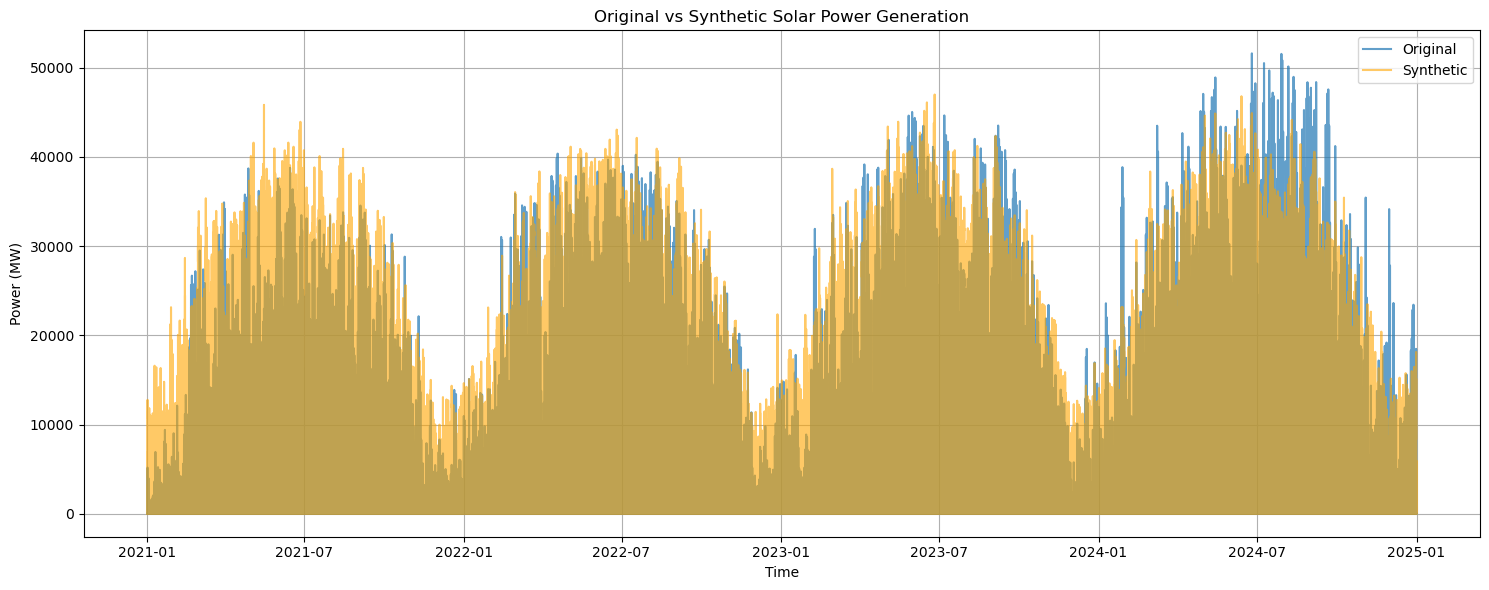

In [51]:
plt.figure(figsize=(15, 6))
plt.plot(df_solar.index, df_solar['Solar-Power-MW'], label='Original', alpha=0.7)
plt.plot(df_solar.index, df_solar['synthetic'], label='Synthetic', color='orange', alpha=0.6)
plt.title('Original vs Synthetic Solar Power Generation')
plt.xlabel('Time')
plt.ylabel('Power (MW)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


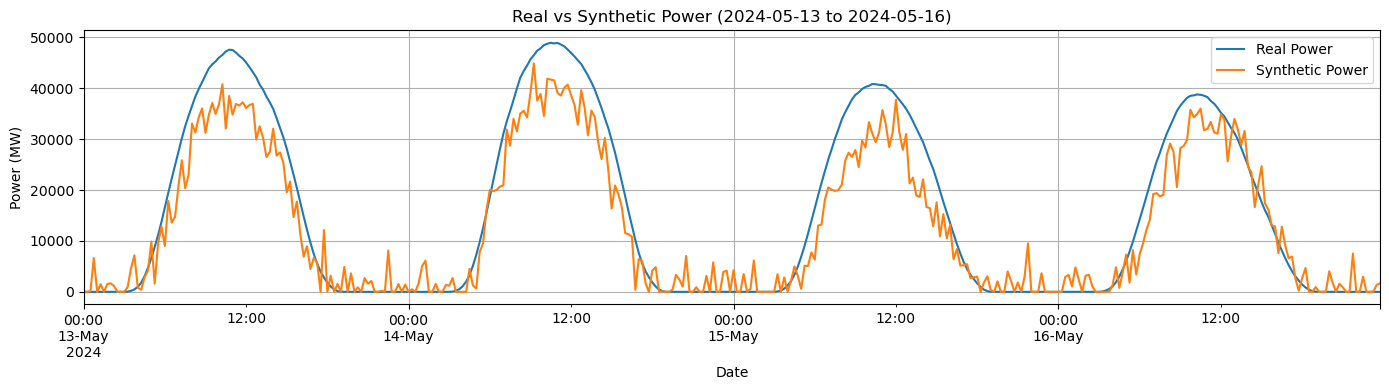

In [54]:
def plot_comparison_range(df_combined, start, end):
    # Ensure the DataFrame is sorted by the DatetimeIndex
    df_combined = df_combined.sort_index()

    # Slice the data within the provided range
    df_window = df_combined.loc[start:end]

    # Plot the real and synthetic power
    df_window[["Solar-Power-MW", "synthetic"]].plot(figsize=(14, 4))
    
    plt.title(f"Real vs Synthetic Power ({start} to {end})")
    plt.xlabel("Date")
    plt.ylabel("Power (MW)")
    plt.legend(["Real Power", "Synthetic Power"])
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Example usage:
plot_comparison_range(df_solar, "2024-05-13", "2024-05-16")


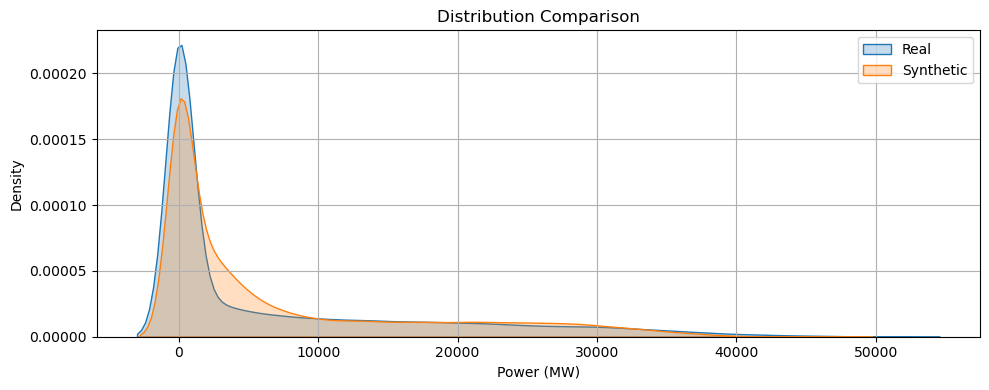

🔎 Evaluation Metrics:
   MAE  = 2587.95 MW
   RMSE = 4197.01 MW
   R²   = 0.846


In [55]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

def plot_kde_and_metrics(df_combined):
    # Ensure no negative values in synthetic power
   # df_combined["synthetic"] = np.clip(df_combined["synthetic"], 0, None)

    # KDE distribution comparison
    y_true = df_solar["Solar-Power-MW"]
    y_pred = df_solar["synthetic"]

    plt.figure(figsize=(10, 4))
    sns.kdeplot(y_true, label="Real", shade=True)
    sns.kdeplot(y_pred, label="Synthetic", shade=True)
    plt.title("Distribution Comparison")
    plt.xlabel("Power (MW)")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # Evaluation metrics
    y_true = y_true.values
    y_pred = y_pred.values

    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mape = np.mean(np.abs((y_true - y_pred) / np.maximum(y_true, 1e-3))) * 100
    r2 = r2_score(y_true, y_pred)

    print(f"🔎 Evaluation Metrics:")
    print(f"   MAE  = {mae:.2f} MW")
    print(f"   RMSE = {rmse:.2f} MW")
    print(f"   R²   = {r2:.3f}")

# Example usage:
plot_kde_and_metrics(df_solar)


In [56]:
df_solar['residual_daily']=df_solar["Solar-Power-MW"] - df_solar["synthetic"]

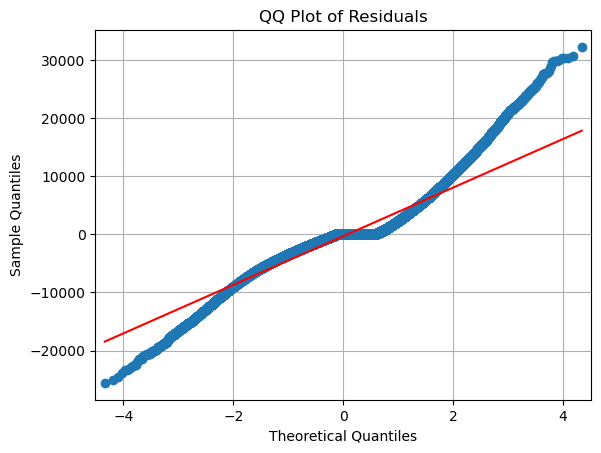

In [57]:
from statsmodels.graphics.gofplots import qqplot
qqplot(df_solar['residual_daily'].dropna(), line='s')
plt.title("QQ Plot of Residuals")
plt.grid(True)
plt.show()


# Phase 2:  Forecasting models

In [58]:
# Step 1: Convert index to datetime (if not already)
df_modeling.index = pd.to_datetime(df_modeling.index)

# Step 2: Resample to hourly mean
df_hourly = df_modeling.resample("H").mean()

# Step 3: Split into train and test sets
train_series = df_hourly[df_hourly.index < "2025-01-01"]
test_series_2025 = df_hourly[df_hourly.index >= "2025-01-01"]

# Step 4: Create second test_series between 2025-01-01 and 2025-02-01
test_series = df_hourly[(df_hourly.index >= "2025-01-01") & (df_hourly.index <= "2025-02-01")]



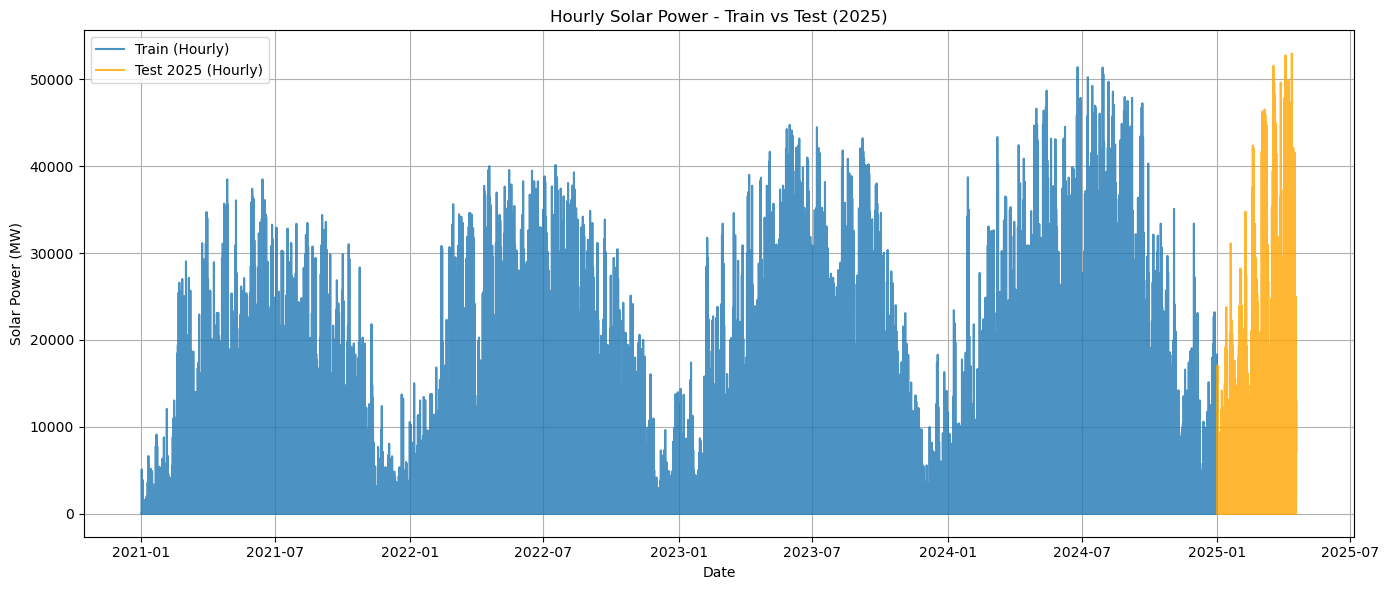

In [59]:
plt.figure(figsize=(14,6))
plt.plot(train_series.index, train_series, label='Train (Hourly)', alpha=0.8)
plt.plot(test_series_2025.index, test_series_2025, label='Test 2025 (Hourly)', alpha=0.8, color='orange')

plt.title("Hourly Solar Power - Train vs Test (2025)")
plt.xlabel("Date")
plt.ylabel("Solar Power (MW)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [60]:
print("Train NaNs:", train_series.isna().sum())
print("Test NaNs:", test_series.isna().sum())
print("Test NaNs:", test_series_2025.isna().sum())


Train NaNs: Solar-Power-MW    7
dtype: int64
Test NaNs: Solar-Power-MW    0
dtype: int64
Test NaNs: Solar-Power-MW    1
dtype: int64


In [61]:
train_series = train_series.ffill()
test_series = test_series.ffill()


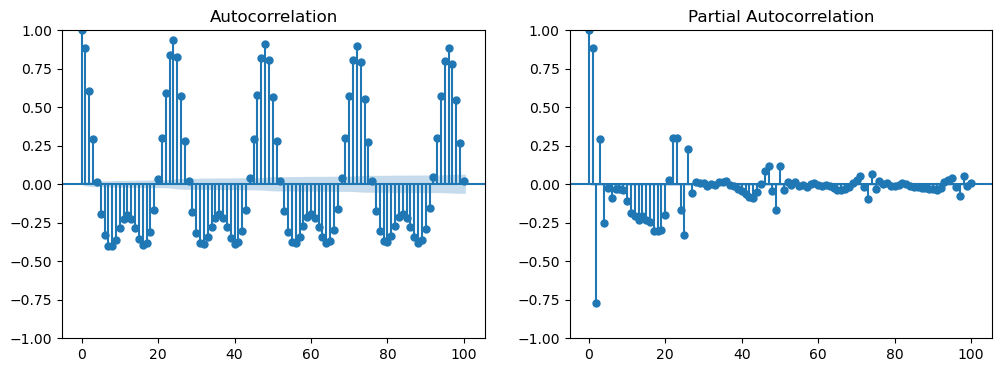

In [62]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
residuals = df_hourly.diff().dropna()

fig, axes = plt.subplots(1, 2, figsize=(12, 4))
plot_acf(residuals, ax=axes[0], lags=100)
plot_pacf(residuals, ax=axes[1], lags=100)
plt.show()

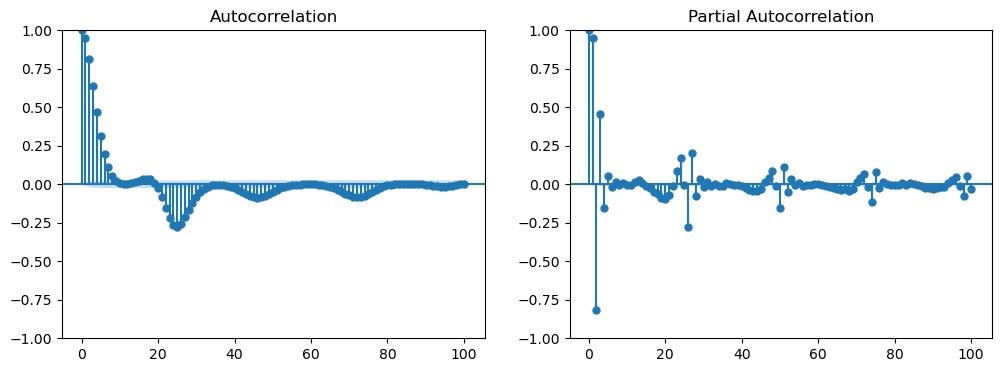

In [63]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
residuals = df_hourly.diff(periods=24).dropna()

fig, axes = plt.subplots(1, 2, figsize=(12, 4))
plot_acf(residuals, ax=axes[0], lags=100)
plot_pacf(residuals, ax=axes[1], lags=100)
plt.show()

In [64]:
#pip install pmdarima



In [65]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
import pmdarima as pm


## Naive Forecast

✅ Naive Forecast 

In [66]:
# Naive forecast: repeat the last value of the training set
train_series_smooth = train_series.rolling(window=24).mean()  # 24-hour rolling window (1 day)
last_non_zero_smooth = train_series_smooth.dropna().iloc[-1]

naive_forecast = pd.Series(
    [last_non_zero_smooth] * len(test_series),
    index=test_series.index
)



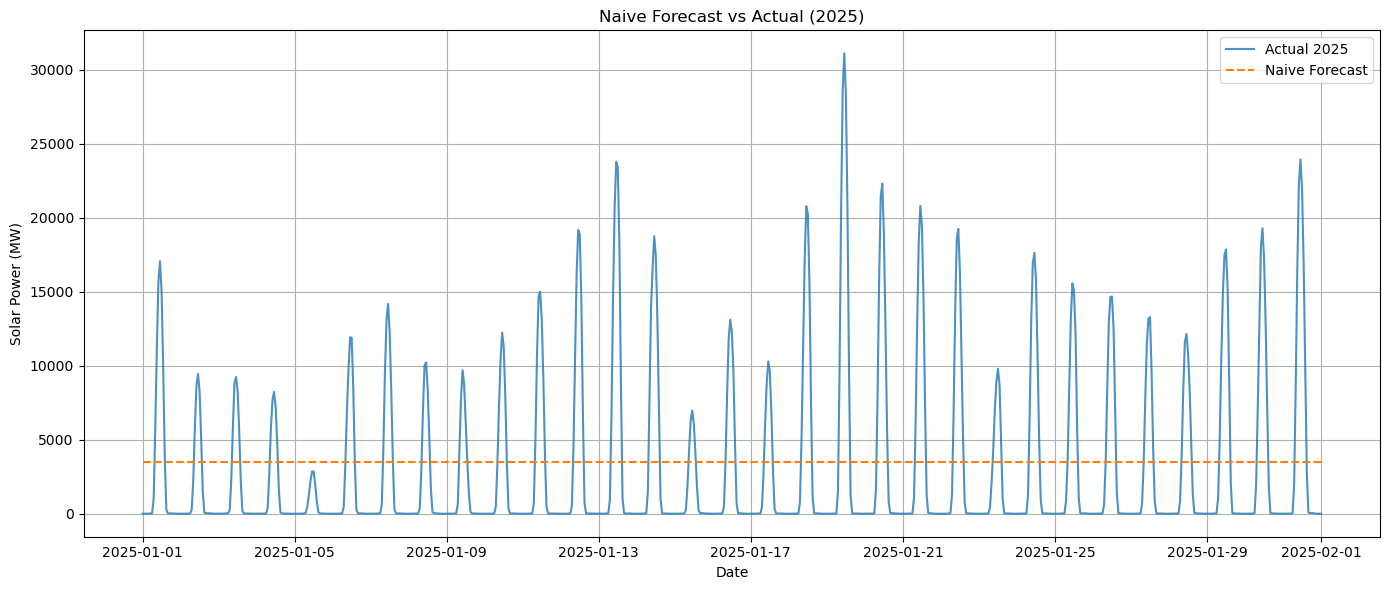

In [67]:
plt.figure(figsize=(14,6))
plt.plot(test_series.index, test_series, label="Actual 2025", alpha=0.8)
plt.plot(naive_forecast.index, naive_forecast, label="Naive Forecast", linestyle='--')
plt.title("Naive Forecast vs Actual (2025)")
plt.xlabel("Date")
plt.ylabel("Solar Power (MW)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [68]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
mae_naive = mean_absolute_error(test_series, naive_forecast)
rmse_naive = np.sqrt(mean_squared_error(test_series, naive_forecast))

print(f"Naive Forecast → MAE: {mae_naive:.2f}, RMSE: {rmse_naive:.2f}")


Naive Forecast → MAE: 4466.05, RMSE: 5686.62


## Holt-Winters Exponential Smoothing 

In [69]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

# Fit the Holt-Winters model
hw_model = ExponentialSmoothing(
    train_series, 
    trend='add',  # Additive trend (you can try 'multiplicative' if needed)
    seasonal='add',  # Additive seasonality (use 'multiplicative' if required)
    seasonal_periods=120  # Periodicity of data (e.g., 24 hours for daily seasonality)
).fit()

# Forecast the test period
hw_forecast = hw_model.forecast(len(test_series))


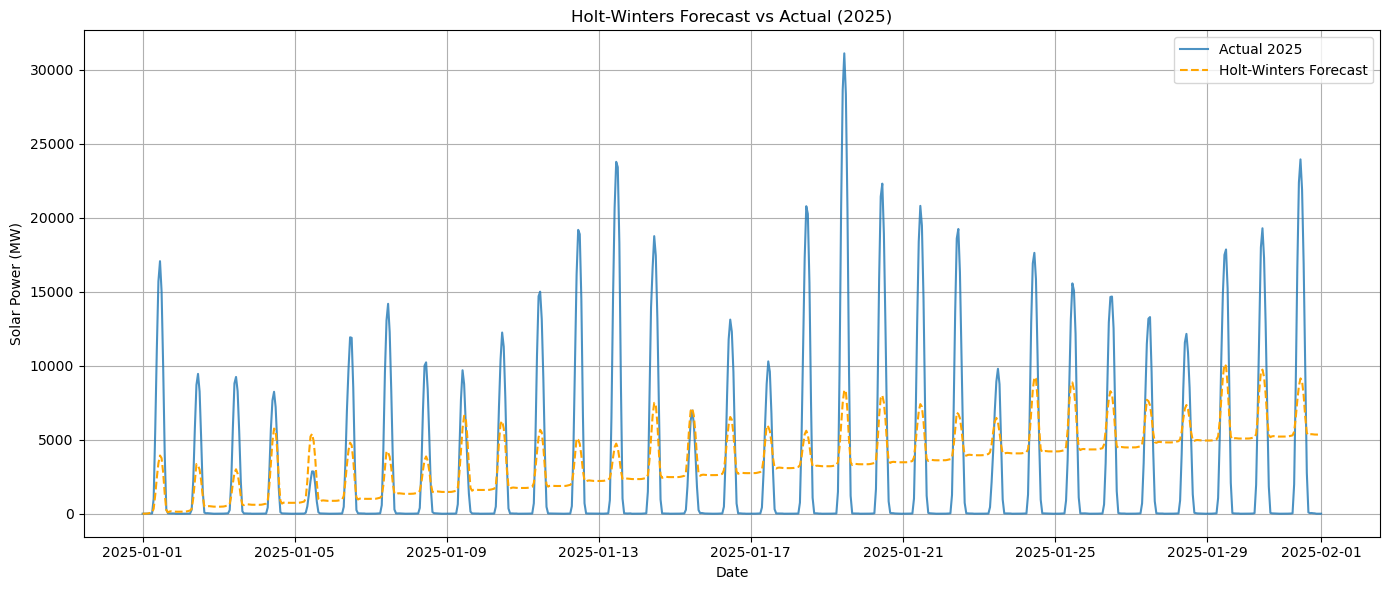

In [70]:
# Plot the Holt-Winters forecast against the actual data
plt.figure(figsize=(14,6))
plt.plot(test_series.index, test_series, label="Actual 2025", alpha=0.8)
plt.plot(hw_forecast.index, hw_forecast, label="Holt-Winters Forecast", linestyle='--', color='orange')
plt.title("Holt-Winters Forecast vs Actual (2025)")
plt.xlabel("Date")
plt.ylabel("Solar Power (MW)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [80]:
offset = 1e-2  # or a small constant like 0.1 MW

## When using multiplicative trend or seasonality in Holt-Winters models, the time series values must be strictly positive (i.e., no zeros or negatives) because multiplication with zero or negative values breaks the math behind the model.

train_shifted = train_series + offset
from statsmodels.tsa.holtwinters import ExponentialSmoothing

hw_model_mul = ExponentialSmoothing(
    train_shifted,
    trend='add',  # 'add' 
    seasonal='mul',
    seasonal_periods=24
).fit()

# Forecast (still shifted)
hw_forecast_shifted = hw_model_mul.forecast(len(test_series))

# Remove the offset
hw_forecast = hw_forecast_shifted - offset


In [81]:
# AIC, BIC, and Log-Likelihood for the multiplicative HW model
print(f"AIC: {hw_model_mul.aic}")
print(f"BIC: {hw_model_mul.bic}")


AIC: 536308.9017702524
BIC: 536545.9206155596


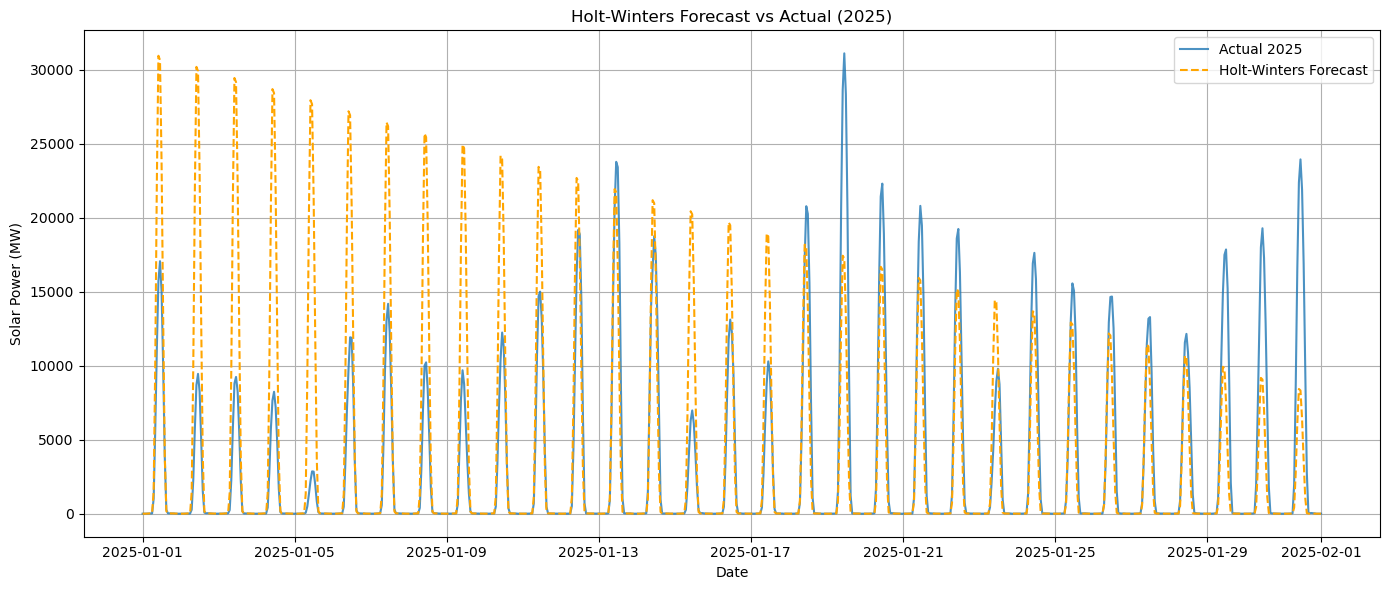

In [82]:
# Plot the Holt-Winters forecast against the actual data
plt.figure(figsize=(14,6))
plt.plot(test_series.index, test_series, label="Actual 2025", alpha=0.8)
plt.plot(hw_forecast.index, hw_forecast, label="Holt-Winters Forecast", linestyle='--', color='orange')
plt.title("Holt-Winters Forecast vs Actual (2025)")
plt.xlabel("Date")
plt.ylabel("Solar Power (MW)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


## Auto ARIMA with full search

In [63]:
from pmdarima import auto_arima

# Run auto ARIMA with extended search space
#auto_model = auto_arima(
    train_series,
    start_p=20, max_p=30,
    start_q=20, max_q=30,
    d=None,               # Let it test both 1 and 2 automatically
    max_d=1,
    seasonal=False,       # This is plain ARIMA, no seasonality
    stepwise=True,       # False Full grid search (slower, but thorough)
    suppress_warnings=True,
    error_action='ignore',
    trace=True             # Show progress
)


IndentationError: unexpected indent (1053386506.py, line 5)

In [64]:
data = [
    ("ARIMA(0,1,0)", 664538.602, 0.47),
    ("ARIMA(1,1,0)", 611002.339, 0.53),
    ("ARIMA(0,1,1)", 623140.364, 5.58),
    ("ARIMA(0,1,0)", 664536.602, 0.34),
    ("ARIMA(2,1,0)", 578491.824, 1.67),
    ("ARIMA(3,1,0)", 575178.657, 1.71),
    ("ARIMA(4,1,0)", 573039.854, 2.21),
    ("ARIMA(5,1,0)", 573006.374, 2.68),
    ("ARIMA(6,1,0)", 572704.005, 3.41),
    ("ARIMA(7,1,0)", 572668.630, 3.66),
    ("ARIMA(8,1,0)", 572629.083, 5.89),
    ("ARIMA(9,1,0)", 572586.497, 6.62),
    ("ARIMA(10,1,0)", 572146.924, 8.55),
    ("ARIMA(11,1,0)", 570859.265, 9.52),
    ("ARIMA(12,1,0)", 569172.180, 11.72),
    ("ARIMA(13,1,0)", 567326.236, 13.05),
    ("ARIMA(14,1,0)", 565768.238, 16.47),
    ("ARIMA(15,1,0)", 563955.884, 15.40),
    ("ARIMA(16,1,0)", float('inf'), 20.74),
    ("ARIMA(15,1,1)", 565266.584, 139.70),
    ("ARIMA(14,1,1)", 558690.672, 165.96),
    ("ARIMA(13,1,1)", 568660.788, 121.95),
    ("ARIMA(14,1,2)", 559207.141, 169.38),
    ("ARIMA(13,1,2)", 560146.496, 140.64),
    ("ARIMA(15,1,2)", 557983.272, 160.61),
    ("ARIMA(16,1,2)", 556901.923, 217.41),
    ("ARIMA(16,1,1)", 555812.983, 214.47),
    ("ARIMA(17,1,1)", 553944.294, 217.75),
    ("ARIMA(17,1,0)", float('inf'), 23.44),
    ("ARIMA(18,1,1)", 552388.984, 240.75),
    ("ARIMA(18,1,0)", float('inf'), 25.90),
]

df = pd.DataFrame(data, columns=["Model", "AIC", "Time_sec"])
print(df)


            Model         AIC  Time_sec
0    ARIMA(0,1,0)  664538.602      0.47
1    ARIMA(1,1,0)  611002.339      0.53
2    ARIMA(0,1,1)  623140.364      5.58
3    ARIMA(0,1,0)  664536.602      0.34
4    ARIMA(2,1,0)  578491.824      1.67
5    ARIMA(3,1,0)  575178.657      1.71
6    ARIMA(4,1,0)  573039.854      2.21
7    ARIMA(5,1,0)  573006.374      2.68
8    ARIMA(6,1,0)  572704.005      3.41
9    ARIMA(7,1,0)  572668.630      3.66
10   ARIMA(8,1,0)  572629.083      5.89
11   ARIMA(9,1,0)  572586.497      6.62
12  ARIMA(10,1,0)  572146.924      8.55
13  ARIMA(11,1,0)  570859.265      9.52
14  ARIMA(12,1,0)  569172.180     11.72
15  ARIMA(13,1,0)  567326.236     13.05
16  ARIMA(14,1,0)  565768.238     16.47
17  ARIMA(15,1,0)  563955.884     15.40
18  ARIMA(16,1,0)         inf     20.74
19  ARIMA(15,1,1)  565266.584    139.70
20  ARIMA(14,1,1)  558690.672    165.96
21  ARIMA(13,1,1)  568660.788    121.95
22  ARIMA(14,1,2)  559207.141    169.38
23  ARIMA(13,1,2)  560146.496    140.64


In [103]:
from statsmodels.tsa.arima.model import ARIMA

# Fit ARIMA model on training data
arima_model = ARIMA(train_series, order=(24, 0,1 )).fit()



In [104]:
forecast_object = arima_model.get_forecast(steps=len(test_series))
arima_model_forecast = forecast_object.predicted_mean  # Forecasted values
arima_model_conf_int = forecast_object.conf_int(alpha=0.05)  # Confidence intervals
arima_model_stderr = forecast_object.se_mean  # Standard errors of the forecasts


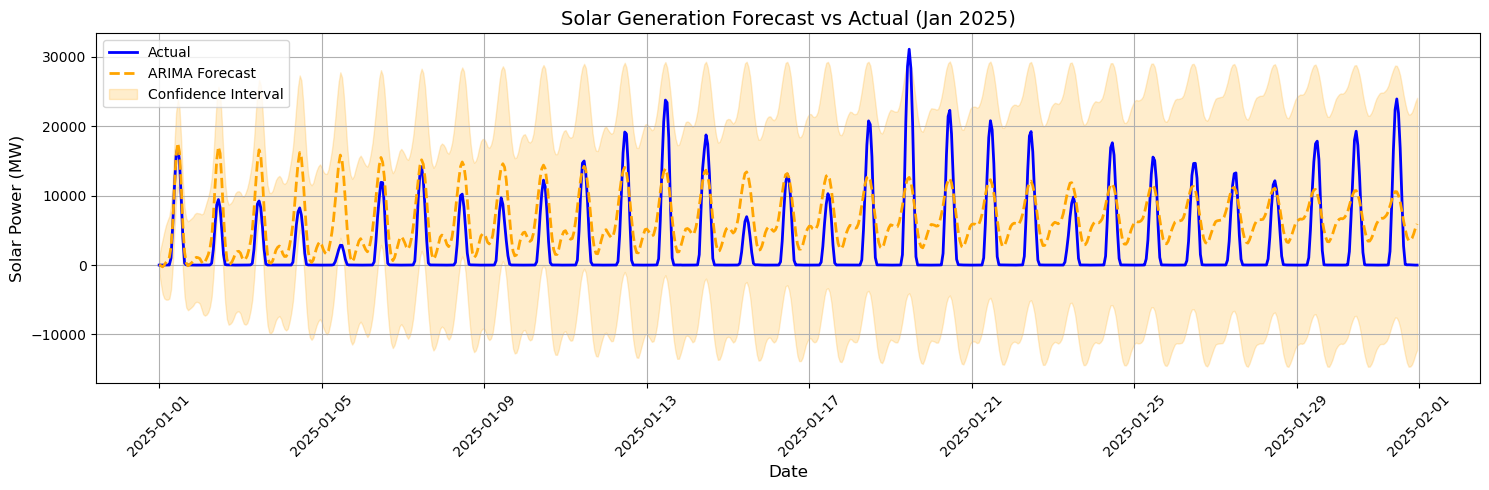

In [105]:
# Ensure the forecast and confidence intervals are in the correct format

# Filter the data for January 2025 (or any other date range you want)
start_date = '2025-01-01'
end_date = '2025-01-31'
actual = test_series.loc[start_date:end_date]
forecasted = arima_model_forecast.loc[start_date:end_date]
ci = arima_model_conf_int.loc[start_date:end_date]

# Plotting the actual vs forecasted values, including confidence intervals
plt.figure(figsize=(15, 5))
plt.plot(actual.index, actual, label='Actual', color='blue', linewidth=2)
plt.plot(forecasted.index, forecasted, label='ARIMA Forecast', linestyle='--', color='orange', linewidth=2)

# Plot the confidence intervals as shaded regions
plt.fill_between(ci.index, ci["lower Solar-Power-MW"], ci["upper Solar-Power-MW"], color='orange', alpha=0.2, label='Confidence Interval')

# Adding titles and labels
plt.title('Solar Generation Forecast vs Actual (Jan 2025)', fontsize=14)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Solar Power (MW)', fontsize=12)
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()

# Show the plot
plt.show()


In [106]:
from statsmodels.tsa.arima.model import ARIMA

# Fit ARIMA model on training data
arima_model1 = ARIMA(train_series, order=(4, 1, 3)).fit()


In [107]:
forecast_object = arima_model1.get_forecast(steps=len(test_series))
arima_model1_forecast = forecast_object.predicted_mean  # Forecasted values
arima_model1_conf_int = forecast_object.conf_int(alpha=0.05)  # Confidence intervals
arima_model1_stderr = forecast_object.se_mean  # Standard errors of the forecasts

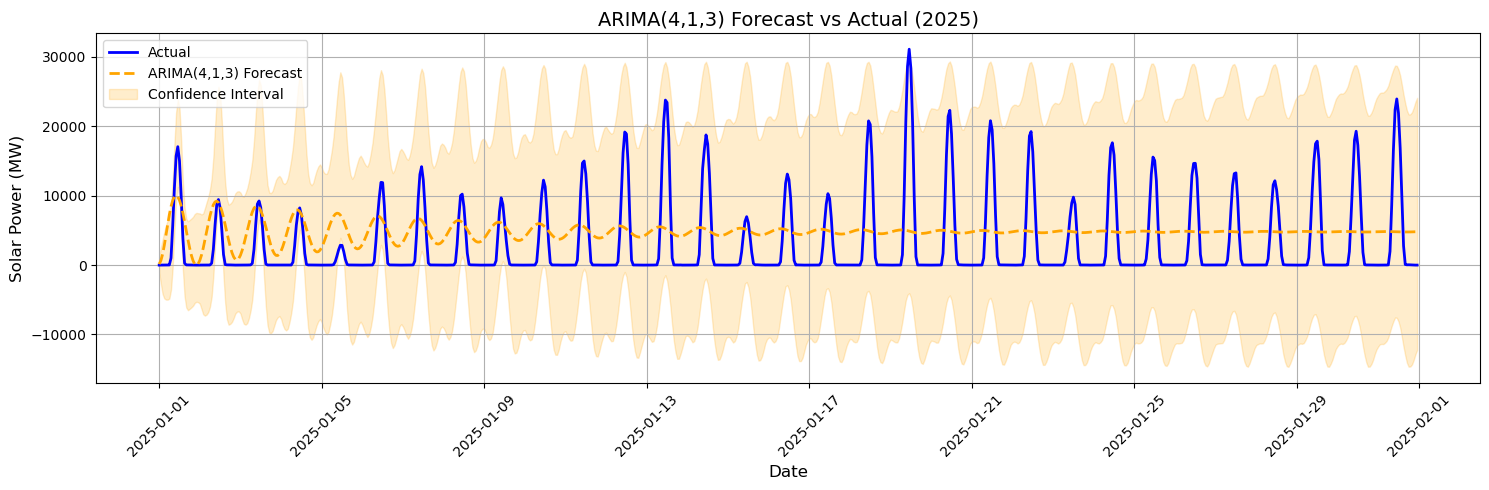

In [108]:
# Ensure the forecast and confidence intervals are in the correct format

# Filter the data for January 2025 (or any other date range you want)
start_date = '2025-01-01'
end_date = '2025-01-31'
actual = test_series.loc[start_date:end_date]
forecasted = arima_model1_forecast.loc[start_date:end_date]
ci = arima_model_conf_int.loc[start_date:end_date]

# Plotting the actual vs forecasted values, including confidence intervals
plt.figure(figsize=(15, 5))
plt.plot(actual.index, actual, label='Actual', color='blue', linewidth=2)
plt.plot(forecasted.index, forecasted, label='ARIMA(4,1,3) Forecast', linestyle='--', color='orange', linewidth=2)

# Plot the confidence intervals as shaded regions
plt.fill_between(ci.index, ci["lower Solar-Power-MW"], ci["upper Solar-Power-MW"], color='orange', alpha=0.2, label='Confidence Interval')

# Adding titles and labels
plt.title('ARIMA(4,1,3) Forecast vs Actual (2025)', fontsize=14)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Solar Power (MW)', fontsize=12)
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()

# Show the plot
plt.show()


## Sarima 

In [109]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

sarima_model = SARIMAX(
    train_series,
    order=(4, 1, 3),               # ARIMA(p,d,q)
    seasonal_order=(1, 1, 1, 24),  # (P,D,Q,s) — daily seasonality (24 hours)
    enforce_stationarity=False,
    enforce_invertibility=False
)


In [110]:
results = sarima_model.fit(disp=False)


In [111]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                       Solar-Power-MW   No. Observations:                35065
Model:             SARIMAX(4, 1, 3)x(1, 1, [1], 24)   Log Likelihood             -266497.819
Date:                              Sun, 11 May 2025   AIC                         533015.639
Time:                                      17:11:45   BIC                         533100.273
Sample:                                  12-31-2020   HQIC                        533042.596
                                       - 12-31-2024                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.1081      0.378      2.929      0.003       0.367       1.850
ar.L2          0.2354      0.700      0.336      0.737      -1.137       1.608
ar.L3         -0.6654      0.439     -1.516      0.130      -1.526       0.195
ar.L4          0.2010      0.091      2.211      0.027       0.023       0.379
ma.L1          0.1230      0.379      0.325      0.745      -0.619       0.865
ma.L2         -0.8552      0.235     -3.643      0.000      -1.315      -0.395
ma.L3         -0.2660      0.144     -1.850      0.064      -0.548       0.016
ar.S.L24       0.1422      0.006     22.235      0.000       0.130       0.155
ma.S.L24      -0.8157      0.004   -203.226      0.000      -0.824      -0.808
sigma2      3.389e+05   1903.773    178.003      0.000    3.35e+05    3.43e+05
===================================================================================
Ljung-Box (L1) (Q):                   0.05   Jarque-Bera (JB):             60401.67
Prob(Q):                              0.82   Prob(JB):                         0.00
Heteroskedasticity (H):               1.79   Skew:                             0.13
Prob(H) (two-sided):                  0.00   Kurtosis:                         9.43
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [112]:
forecast = results.get_forecast(len(test_series))
sarima_forecast_mean = forecast.predicted_mean
sarima_conf_int = forecast.conf_int()


In [113]:
sarima_conf_int

lower Solar-Power-MW  upper Solar-Power-MW
2025-01-01 00:00:00          -1152.730463           1129.185992
2025-01-01 01:00:00          -2821.874072           2757.401463
2025-01-01 02:00:00          -4452.790724           4335.476313
2025-01-01 03:00:00          -5762.797837           5603.661408
2025-01-01 04:00:00          -6685.282639           6489.346621
...                                   ...                   ...
2025-01-31 20:00:00         -14400.930530          11897.007586
2025-01-31 21:00:00         -14413.398482          11885.740783
2025-01-31 22:00:00         -14414.002540          11886.352027
2025-01-31 23:00:00         -14414.613338          11886.965433
2025-02-01 00:00:00         -14422.410710          11889.702999

[745 rows x 2 columns]

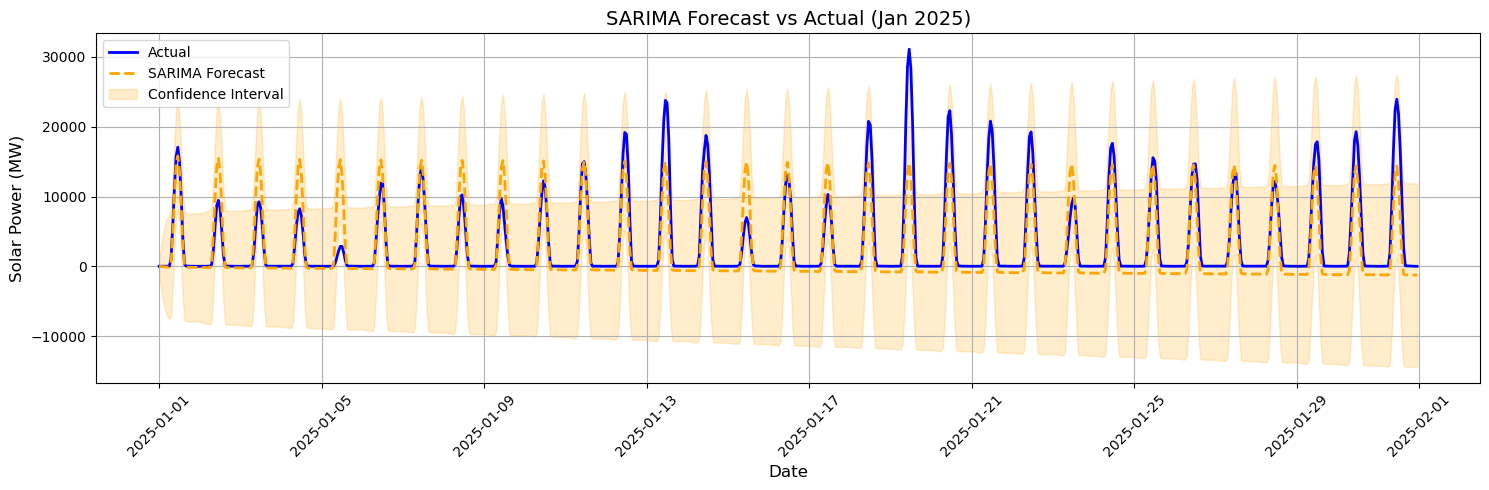

In [114]:
# Filter for January 2025 (or any other date range you want)
start_date = '2025-01-01'
end_date = '2025-01-31'
actual = test_series.loc[start_date:end_date]
forecasted = sarima_forecast_mean.loc[start_date:end_date]
ci = sarima_conf_int.loc[start_date:end_date]

# Plotting the actual vs forecasted values, including confidence intervals
plt.figure(figsize=(15, 5))
plt.plot(actual.index, actual, label='Actual', color='blue', linewidth=2)
plt.plot(forecasted.index, forecasted, label='SARIMA Forecast', linestyle='--', color='orange', linewidth=2)

# Plot the confidence intervals as shaded regions
plt.fill_between(ci.index, ci["lower Solar-Power-MW"], ci["upper Solar-Power-MW"], color='orange', alpha=0.2, label='Confidence Interval')

# Adding titles and labels
plt.title('SARIMA Forecast vs Actual (Jan 2025)', fontsize=14)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Solar Power (MW)', fontsize=12)
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()

# Show the plot
plt.show()


## Sarimax

In [ ]:
#!pip install meteostat


In [ ]:
#!pip install pvlib


In [83]:
from meteostat import Hourly, Stations
from datetime import datetime

# Step 1: Define the date range
start = datetime(2021, 1, 1)
end = datetime.today()

# Step 2: Fetch Leipzig station directly
stations = Stations()
station_leipzig = stations.region('DE').fetch().query('name.str.contains("Leipzig", case=False)')

# Step 3: Fetch weather data for Leipzig station
station_id = station_leipzig.index[0]
data = Hourly(station_id, start, end)
weather = data.fetch()

# Step 4: Specify the weather columns you want to keep
required_columns = ['temp', 'rhum', 'prcp', 'snow', 'wspd', 'coco']

# Step 5: Filter and fill missing data
weather_filtered = weather[required_columns].fillna(method='ffill')

# Step 6: Preview the data
print(weather_filtered.head())


                     temp   rhum  prcp  snow  wspd  coco
time                                                    
2021-01-01 00:00:00   2.8   77.0   0.0   0.0  13.0   4.0
2021-01-01 01:00:00   2.0   81.0   0.0   0.0  11.2   3.0
2021-01-01 02:00:00   2.0   81.0   0.0   0.0   9.4   4.0
2021-01-01 03:00:00   2.0   87.0   0.0   0.0  11.2   7.0
2021-01-01 04:00:00   1.0  100.0   0.1   0.0  13.0  14.0


In [84]:
import pvlib
from datetime import datetime

# Define time range
start = datetime(2021, 1, 1)
end = datetime.today()

# Create hourly time index for Europe/Berlin timezone
times = pd.date_range(start=start, end=end, freq='H', tz='Europe/Berlin')

# Define Leipzig location (latitude and longitude)
# Leipzig coordinates: 51.3397° N, 12.3731° E
location = pvlib.location.Location(latitude=51.3397, longitude=12.3731, tz='Europe/Berlin')

# Get solar position data
solpos = location.get_solarposition(times)

# Get clear-sky irradiance using Ineichen model
clearsky = location.get_clearsky(times, model='ineichen')

# Combine solar position and irradiance into one DataFrame
solar_data_leipzig = pd.concat([solpos, clearsky], axis=1)
# Step 1: Reset index to access the datetime
solar_data_leipzig = solar_data_leipzig.reset_index()

# Step 2: Combine the date and time into a single Date-Time column
solar_data_leipzig['Date-Time'] = solar_data_leipzig['index'].dt.strftime('%Y-%m-%d %H:%M:%S')

# Step 3: Keep only the required columns: Date-Time, ghi, dni, dhi
solar_cleaned = solar_data_leipzig[['Date-Time', 'ghi', 'dni', 'dhi']]

# Preview cleaned data
print(solar_cleaned.head())


             Date-Time  ghi  dni  dhi
0  2021-01-01 00:00:00  0.0  0.0  0.0
1  2021-01-01 01:00:00  0.0  0.0  0.0
2  2021-01-01 02:00:00  0.0  0.0  0.0
3  2021-01-01 03:00:00  0.0  0.0  0.0
4  2021-01-01 04:00:00  0.0  0.0  0.0


In [85]:
# Align indexes and join
# Assuming solar_cleaned, weather_filtered, and df_hourly are already defined

# Ensure the time index is properly set for each DataFrame
solar_cleaned['Date-Time'] = pd.to_datetime(solar_cleaned['Date-Time'])
weather_filtered.index = pd.to_datetime(weather_filtered.index)
df_hourly.index = pd.to_datetime(df_hourly.index)

# Merge the dataframes on the 'Date-Time' or time index
# Adjust according to the names of your actual dataframes and columns

# First, merge solar_cleaned with weather_filtered on the Date-Time
merged_data_1 = pd.merge(solar_cleaned, weather_filtered, how='inner', left_on='Date-Time', right_index=True)

# Then, merge the result with df_hourly on the Date-Time index
df_model_sarima = pd.merge(merged_data_1, df_hourly, how='inner', left_on='Date-Time', right_index=True)

# Step 3: Preview the merged data
print(df_model_sarima.head())


            Date-Time  ghi  dni  dhi  temp   rhum  prcp  snow  wspd  coco  \
0 2021-01-01 00:00:00  0.0  0.0  0.0   2.8   77.0   0.0   0.0  13.0   4.0   
1 2021-01-01 01:00:00  0.0  0.0  0.0   2.0   81.0   0.0   0.0  11.2   3.0   
2 2021-01-01 02:00:00  0.0  0.0  0.0   2.0   81.0   0.0   0.0   9.4   4.0   
3 2021-01-01 03:00:00  0.0  0.0  0.0   2.0   87.0   0.0   0.0  11.2   7.0   
4 2021-01-01 04:00:00  0.0  0.0  0.0   1.0  100.0   0.1   0.0  13.0  14.0   

   Solar-Power-MW  
0            0.00  
1            0.00  
2            0.00  
3            0.65  
4            1.45  


In [87]:
# Convert 'Date-Time' column to datetime
df_model_sarima['Date-Time'] = pd.to_datetime(df_model_sarima['Date-Time'])




In [8]:
#df_model_sarima.to_excel("/Users/mac/Desktop/df_model_sarimax.xlsx", index=False)
df_model_sarima = pd.read_excel("df_model_sarimax.xlsx")


In [9]:
# Set 'Date-Time' as the index for time series modeling
df_model_sarima.set_index('Date-Time', inplace=True)

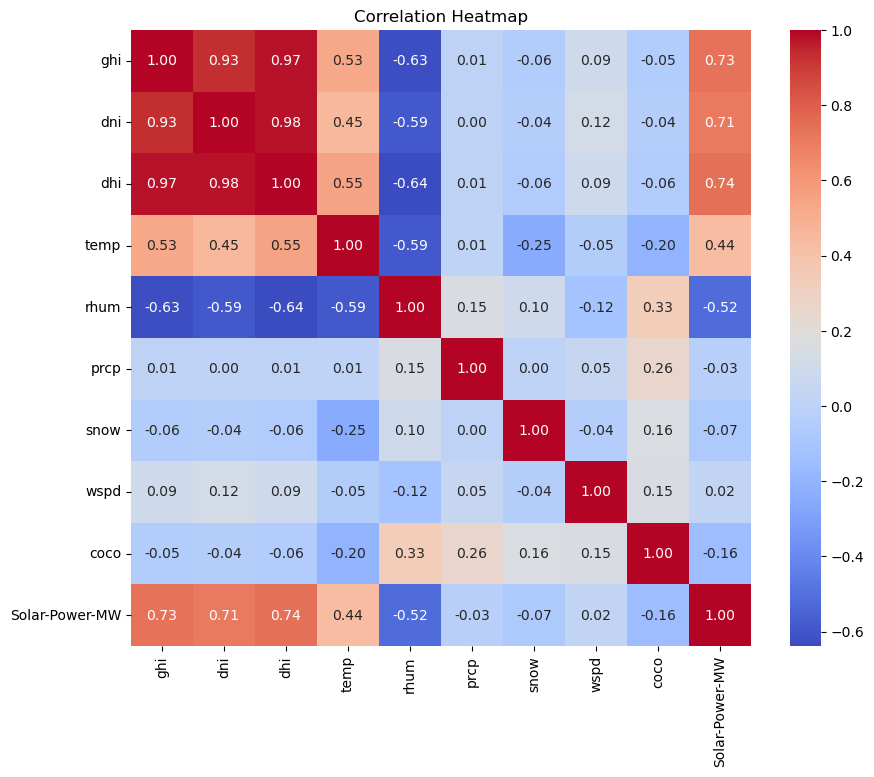

In [10]:
# Plot correlation heatmap
# Compute correlation matrix
corr = df_model_sarima.corr()

# Plot heatmap of correlations
plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Heatmap')
plt.show()


In [11]:
df_model_sarima

ghi         dni         dhi  temp  rhum  prcp  \
Date-Time                                                                   
2021-01-01 00:00:00    0.000000    0.000000    0.000000   2.8    77   0.0   
2021-01-01 01:00:00    0.000000    0.000000    0.000000   2.0    81   0.0   
2021-01-01 02:00:00    0.000000    0.000000    0.000000   2.0    81   0.0   
2021-01-01 03:00:00    0.000000    0.000000    0.000000   2.0    87   0.0   
2021-01-01 04:00:00    0.000000    0.000000    0.000000   1.0   100   0.1   
...                         ...         ...         ...   ...   ...   ...   
2025-04-18 11:00:00  624.134576  759.986796  117.729515  12.3    81   0.0   
2025-04-18 12:00:00  702.420417  787.759724  124.219684  13.2    79   0.0   
2025-04-18 13:00:00  734.672056  797.994445  126.779189  13.7    77   0.0   
2025-04-18 14:00:00  718.490649  792.939367  125.502551  13.4    82   0.0   
2025-04-18 15:00:00  655.105964  771.511568  120.348234  12.5    85   0.0   

                     snow  wspd  coco  Solar-Power-MW  
Date-Time                                              
2021-01-01 00:00:00     0  13.0     4           0.000  
2021-01-01 01:00:00     0  11.2     3           0.000  
2021-01-01 02:00:00     0   9.4     4           0.000  
2021-01-01 03:00:00     0  11.2     7           0.650  
2021-01-01 04:00:00     0  13.0    14           1.450  
...                   ...   ...   ...             ...  
2025-04-18 11:00:00     0  14.8     4       12999.775  
2025-04-18 12:00:00     0  14.8     4       12679.300  
2025-04-18 13:00:00     0  14.8     4       11320.350  
2025-04-18 14:00:00     0  14.8     4        9187.225  
2025-04-18 15:00:00     0  14.8     4        7251.050  

[37647 rows x 10 columns]

In [93]:
# Ensure the index is datetime type
df_model_sarima.index = pd.to_datetime(df_model_sarima.index)

# Split into train and test
train_sarimax = df_model_sarima[df_model_sarima.index.year < 2025]
test_sarimax = df_model_sarima[df_model_sarima.index.year == 2025]

# Show summary
print("Train shape:", train_sarimax.shape)
print("Test shape:", test_sarimax.shape)


Train shape: (35064, 10)
Test shape: (2583, 10)


In [94]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Set up SARIMAX model (example with arbitrary parameters)
sarima_model = SARIMAX(train_sarimax['Solar-Power-MW'],
                       exog=train_sarimax[['dhi', 'temp', 'rhum', 'coco']],
                       order=(4, 1, 3), 
                       seasonal_order=(1, 1, 1, 24))  # Example seasonal order with daily seasonality

# Fit the model
sarima_results = sarima_model.fit()



 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           14     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.70176D+00    |proj g|=  1.01140D-01

At iterate    5    f=  7.64824D+00    |proj g|=  3.98328D-02

At iterate   10    f=  7.64511D+00    |proj g|=  2.79759D-03

At iterate   15    f=  7.64130D+00    |proj g|=  9.24587D-03

At iterate   20    f=  7.63748D+00    |proj g|=  4.47414D-03

At iterate   25    f=  7.63644D+00    |proj g|=  2.53013D-03

At iterate   30    f=  7.63622D+00    |proj g|=  5.73130D-04

At iterate   35    f=  7.63531D+00    |proj g|=  5.01653D-03

At iterate   40    f=  7.61680D+00    |proj g|=  5.22575D-02

At iterate   45    f=  7.61134D+00    |proj g|=  4.32684D-03

At iterate   50    f=  7.61063D+00    |proj g|=  2.56350D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

In [91]:
## Print summary of the results
print(sarima_results.summary())

                                      SARIMAX Results                                       
Dep. Variable:                       Solar-Power-MW   No. Observations:                35064
Model:             SARIMAX(4, 1, 3)x(1, 1, [1], 24)   Log Likelihood             -266863.441
Date:                              Sun, 11 May 2025   AIC                         533754.883
Time:                                      05:41:28   BIC                         533873.382
Sample:                                           0   HQIC                        533792.626
                                            - 35064                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
dhi           -9.0816      1.400     -6.486      0.000     -11.826      -6.337
temp          37.76

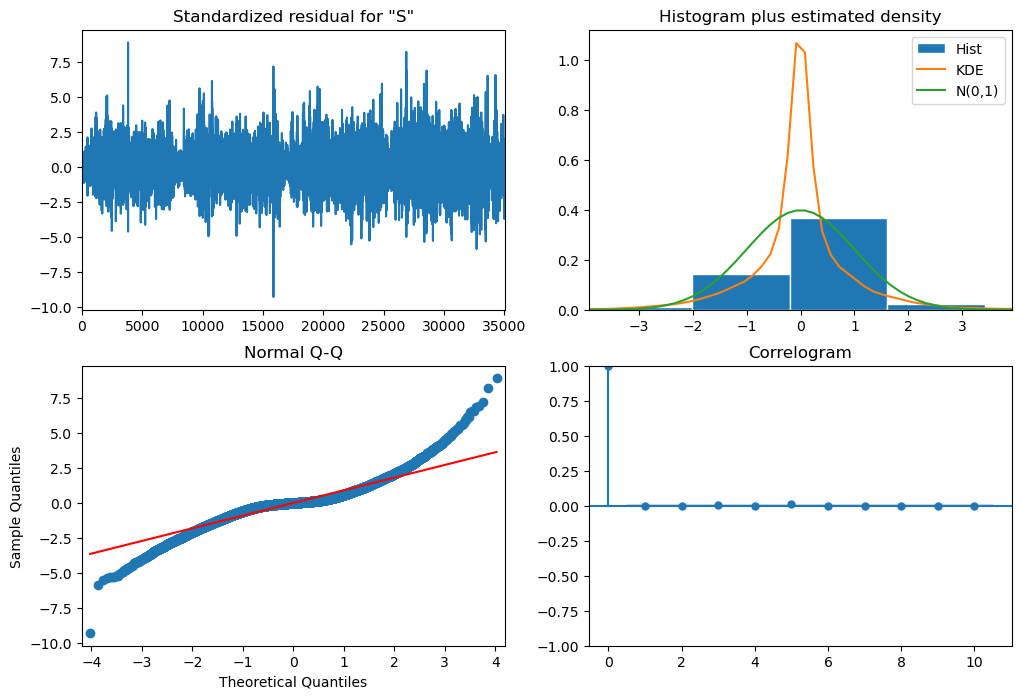

In [95]:
# Plot diagnostics for the fitted SARIMAX model
sarima_results.plot_diagnostics(figsize=(12, 8))
plt.show()


In [96]:
# Extract just January 2025
exog_january = test_sarimax.loc['2025-01-01':'2025-02-01', ['dhi', 'temp', 'rhum', 'coco']]

# Get forecast for exactly that many steps
forecast = sarima_results.get_forecast(steps=len(exog_january), exog=exog_january)

In [97]:
# Extract the predicted mean (point forecast)
sarimax_predicted1 = forecast.predicted_mean

# Optionally: Extract confidence intervals
sarimax_conf_int = forecast.conf_int()


In [98]:
test_sarimax.index = pd.to_datetime(test_sarimax.index)
# Make forecast for full test set
forecast = sarima_results.get_forecast(steps=len(test_sarimax), exog=test_sarimax[['dhi', 'temp', 'rhum', 'coco']])
sarimax_predicted = forecast.predicted_mean
sarimax_conf_int = forecast.conf_int()

# Set index of prediction to match test set
sarimax_predicted.index = test_sarimax.index
sarimax_conf_int.index = test_sarimax.index


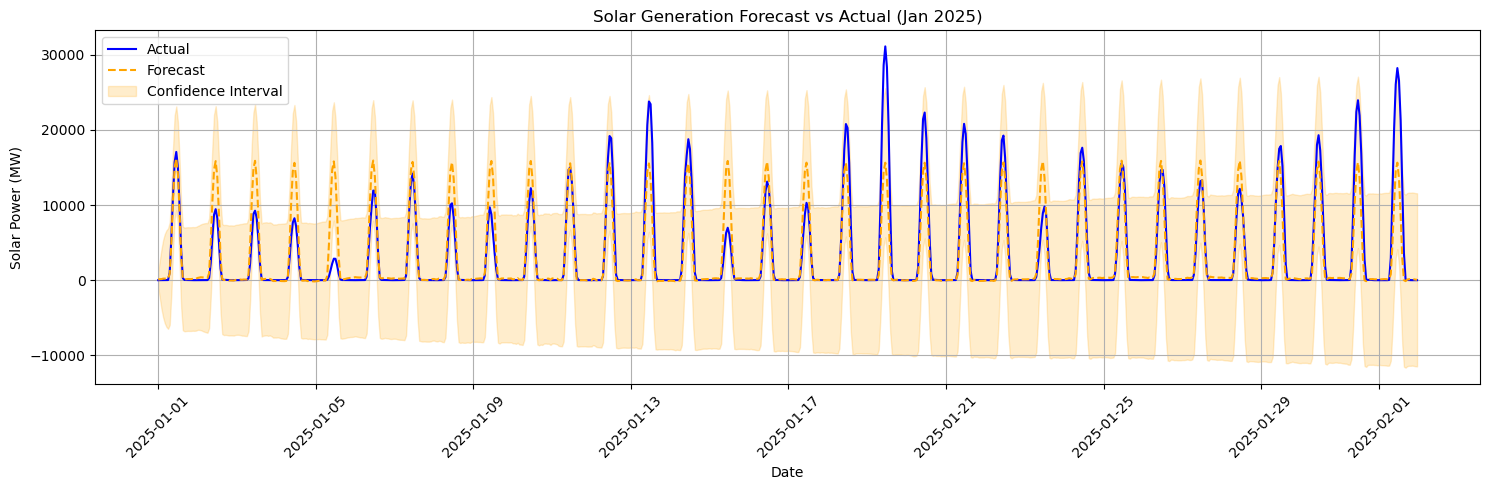

In [102]:
# Slice for January
start_date = '2025-01-01'
end_date = '2025-02-01'
actual = test_sarimax.loc[start_date:end_date, 'Solar-Power-MW']
forecasted = sarimax_predicted.loc[start_date:end_date]
ci = sarimax_conf_int.loc[start_date:end_date]

# Plot
plt.figure(figsize=(15, 5))
plt.plot(actual.index, actual, label='Actual', color='blue')
plt.plot(forecasted.index, forecasted, label='Forecast', linestyle='--', color='orange')
plt.fill_between(ci.index, ci.iloc[:, 0], ci.iloc[:, 1], color='orange', alpha=0.2, label='Confidence Interval')

plt.title('Solar Generation Forecast vs Actual (Jan 2025)')
plt.xlabel('Date')
plt.ylabel('Solar Power (MW)')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


## Selecting the best model 

In [116]:
model_scores = []

# Holt-Winters (check if AIC/BIC are available)
try:
    model_scores.append({
        "model": "Holt-Winters",
        "aic": hw_model_mul.aic,
        "bic": hw_model_mul.bic,
        "llf": hw_model_mul.llf
    })
except AttributeError:
    model_scores.append({
        "model": "Holt-Winters",
        "aic": None,
        "bic": None,
        "llf": None
    })

# ARIMA
model_scores.append({
    "model": "ARIMA",
    "aic": arima_model.aic,
    "bic": arima_model.bic,
    "llf": arima_model.llf
})

# ARIMA v2
model_scores.append({
    "model": "ARIMA v2",
    "aic": arima_model1.aic,
    "bic": arima_model1.bic,
    "llf": arima_model1.llf
})

# SARIMA
model_scores.append({
    "model": "SARIMA",
    "aic": results.aic,
    "bic": results.bic,
    "llf": results.llf
})

# SARIMAX
model_scores.append({
    "model": "SARIMAX",
    "aic": sarima_results.aic,
    "bic": sarima_results.bic,
    "llf": sarima_results.llf
})

# Create a summary table
scores_df = pd.DataFrame(model_scores)
scores_df_sorted = scores_df.sort_values(by="aic")
print(scores_df_sorted)


          model            aic            bic            llf
3        SARIMA  533015.638684  533100.273146 -266497.819342
4       SARIMAX  533746.598081  533865.097119 -266859.299040
1         ARIMA  545580.456614  545809.010500 -272763.228307
2      ARIMA v2  564847.491792  564915.211234 -282415.745896
0  Holt-Winters            NaN            NaN            NaN


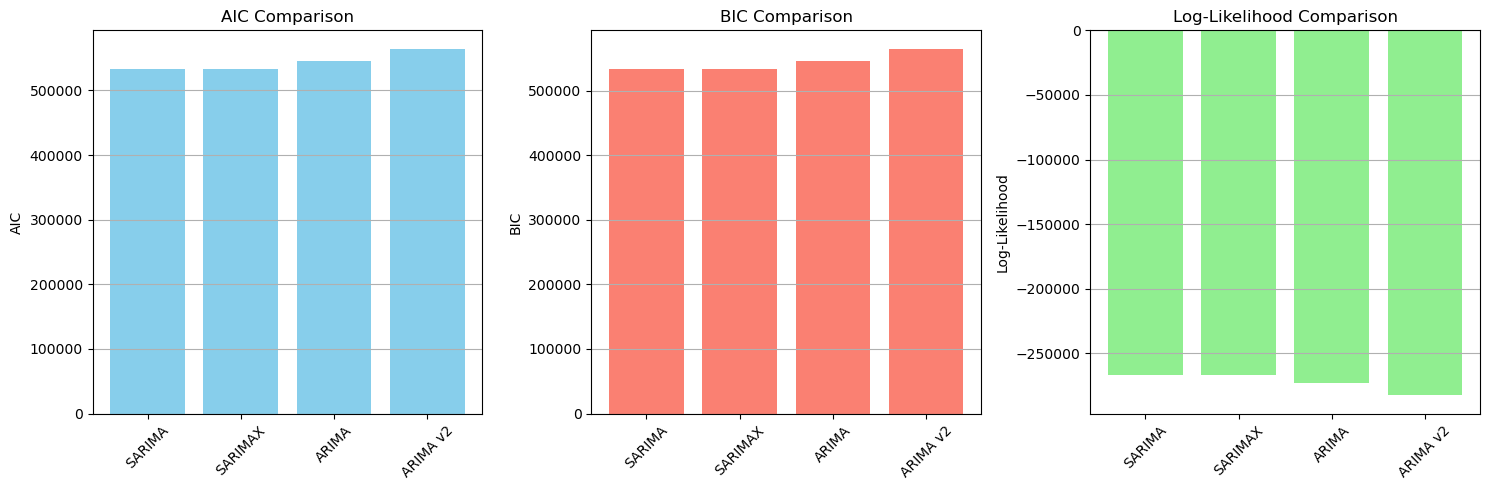

In [117]:
def plot_model_selection(scores_df):
    models = scores_df['model']

    plt.figure(figsize=(15, 5))

    # AIC
    plt.subplot(1, 3, 1)
    plt.bar(models, scores_df['aic'], color='skyblue')
    plt.title('AIC Comparison')
    plt.ylabel('AIC')
    plt.xticks(rotation=45)
    plt.grid(axis='y')

    # BIC
    plt.subplot(1, 3, 2)
    plt.bar(models, scores_df['bic'], color='salmon')
    plt.title('BIC Comparison')
    plt.ylabel('BIC')
    plt.xticks(rotation=45)
    plt.grid(axis='y')

    # Log-Likelihood
    plt.subplot(1, 3, 3)
    plt.bar(models, scores_df['llf'], color='lightgreen')
    plt.title('Log-Likelihood Comparison')
    plt.ylabel('Log-Likelihood')
    plt.xticks(rotation=45)
    plt.grid(axis='y')

    plt.tight_layout()
    plt.show()

# Run the plot
plot_model_selection(scores_df_sorted)


In [123]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
# Check if all forecasts are aligned with the test series (Ensure consistent length)
def align_forecast(test_series, forecast):
    if len(forecast) != len(test_series):
        forecast = forecast[:len(test_series)]
    return forecast

# Apply alignment to all forecasts
hw_forecast = align_forecast(test_series, hw_forecast)
arima_forecast = align_forecast(test_series, arima_model_forecast)
arima_forecast1 = align_forecast(test_series, arima_model1_forecast)
sarima_forecast_filled = align_forecast(test_series, sarima_forecast_mean)
sarimax_pred = align_forecast(test_series, forecasted)

# Calculate MAE and RMSE for each model

# Holt-Winters
mae_hw = mean_absolute_error(test_series, hw_forecast)
rmse_hw = np.sqrt(mean_squared_error(test_series, hw_forecast))
print(f"Holt-Winters → MAE: {mae_hw:.2f}, RMSE: {rmse_hw:.2f}")

# ARIMA
mae_arima = mean_absolute_error(test_series, arima_model_forecast)
rmse_arima = np.sqrt(mean_squared_error(test_series, arima_model_forecast))
print(f"ARIMA → MAE: {mae_arima:.2f}, RMSE: {rmse_arima:.2f}")

# ARIMA v2
mae_arima2 = mean_absolute_error(test_series, arima_model1_forecast)
rmse_arima2 = np.sqrt(mean_squared_error(test_series, arima_model1_forecast))
print(f"ARIMA v2 → MAE: {mae_arima2:.2f}, RMSE: {rmse_arima2:.2f}")

# SARIMA
mae_sarima = mean_absolute_error(test_series, sarima_forecast_mean)
rmse_sarima = np.sqrt(mean_squared_error(test_series, sarima_forecast_mean))
print(f"SARIMA → MAE: {mae_sarima:.2f}, RMSE: {rmse_sarima:.2f}")

# SARIMAX
mae_sarimax = mean_absolute_error(actual, forecasted)
rmse_sarimax = np.sqrt(mean_squared_error(actual, forecasted))
print(f"SARIMAX → MAE: {mae_sarimax:.2f}, RMSE: {rmse_sarimax:.2f}")

# Storing results in a summary table
forecast_results = [
    {"model": "Holt-Winters", "mae": mae_hw, "rmse": rmse_hw},
    {"model": "ARIMA", "mae": mae_arima, "rmse": rmse_arima},
    {"model": "ARIMA v2", "mae": mae_arima2, "rmse": rmse_arima2},
    {"model": "SARIMA", "mae": mae_sarima, "rmse": rmse_sarima},
    {"model": "SARIMAX", "mae": mae_sarimax, "rmse": rmse_sarimax},
]

# Create the DataFrame for comparison
import pandas as pd
forecast_df = pd.DataFrame(forecast_results)
forecast_df_sorted = forecast_df.sort_values(by="rmse")

# Print the sorted summary table
print("\nModel Comparison (Sorted by RMSE):")
print(forecast_df_sorted)


Holt-Winters → MAE: 2010.51, RMSE: 4651.62
ARIMA → MAE: 4462.13, RMSE: 5076.36
ARIMA v2 → MAE: 4868.37, RMSE: 5744.13
SARIMA → MAE: 1661.47, RMSE: 2754.89
SARIMAX → MAE: 1662.00, RMSE: 2756.35

Model Comparison (Sorted by RMSE):
          model          mae         rmse
3        SARIMA  1661.469875  2754.888877
4       SARIMAX  1662.000945  2756.348690
0  Holt-Winters  2010.507467  4651.615649
1         ARIMA  4462.128060  5076.361625
2      ARIMA v2  4868.366377  5744.133398


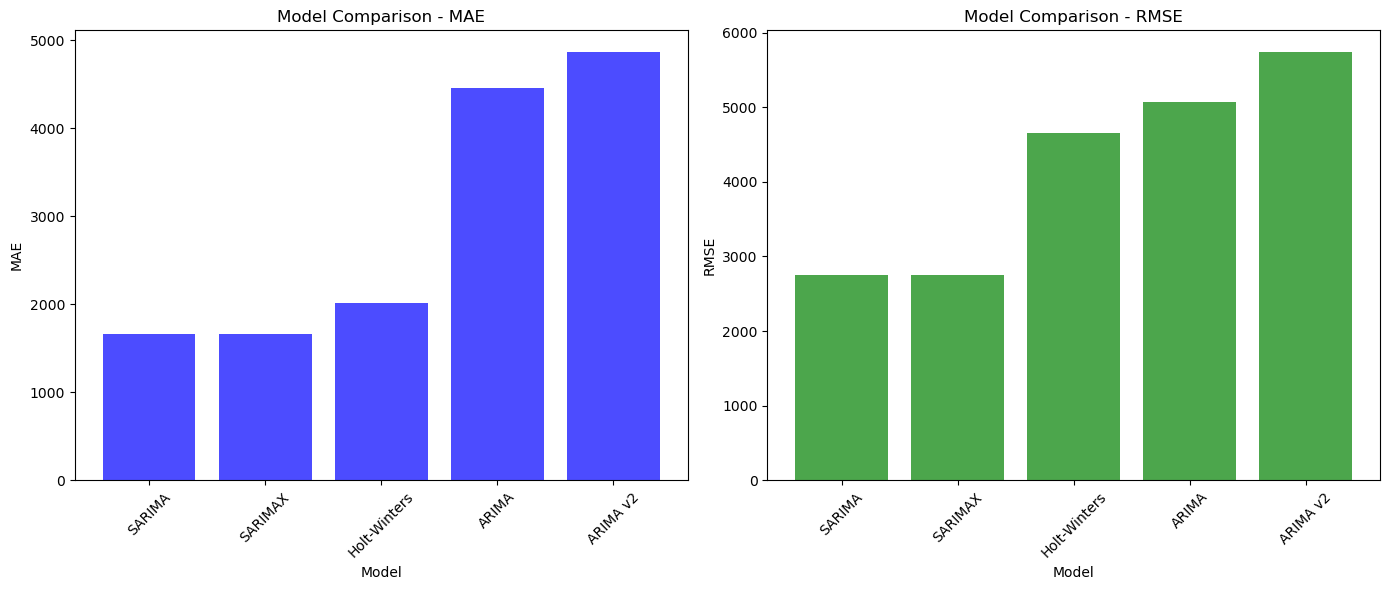

In [124]:
# Create the DataFrame for comparison
forecast_df = pd.DataFrame(forecast_results)

# Plotting MAE and RMSE for each model
fig, ax = plt.subplots(1, 2, figsize=(14, 6))

# Bar plot for MAE
ax[0].bar(forecast_df_sorted['model'], forecast_df_sorted['mae'], color='blue', alpha=0.7)
ax[0].set_title('Model Comparison - MAE')
ax[0].set_xlabel('Model')
ax[0].set_ylabel('MAE')
ax[0].tick_params(axis='x', rotation=45)

# Bar plot for RMSE
ax[1].bar(forecast_df_sorted['model'], forecast_df_sorted['rmse'], color='green', alpha=0.7)
ax[1].set_title('Model Comparison - RMSE')
ax[1].set_xlabel('Model')
ax[1].set_ylabel('RMSE')
ax[1].tick_params(axis='x', rotation=45)

# Adjust layout
plt.tight_layout()
plt.show()

## Optional LSTM

In [70]:
#pip install tensorflow


In [10]:
train_series = df_modeling[df_modeling.index < "2025-01-01"]
test_series = df_modeling[df_modeling.index >= "2025-01-01"]

In [11]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

# Assuming you have two time series: train_series and test_series
scaler = MinMaxScaler()

# Scaling the training and testing data
train_scaled = scaler.fit_transform(train_series.values.reshape(-1, 1))
test_scaled = scaler.transform(test_series.values.reshape(-1, 1))

# Function to create sequences for LSTM
def create_sequences(data, window_size):
    X, y = [], []
    for i in range(window_size, len(data)):
        X.append(data[i - window_size:i])  # Creating the input sequence
        y.append(data[i])  # Creating the corresponding target value
    return np.array(X), np.array(y)

# Window size parameter (number of past hours to consider)
window_size = 24

# Create X and y for training and testing
X_train, y_train = create_sequences(train_scaled, window_size)
X_test, y_test = create_sequences(test_scaled, window_size)


In [12]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping

# Create the model
model = Sequential()
model.add(LSTM(64, activation='relu', input_shape=(window_size, 1)))
model.add(Dense(1))

# Compile the model
model.compile(optimizer='adam', loss='mse')
model.summary()

# Set up EarlyStopping to prevent overfitting
early_stop = EarlyStopping(
    monitor='val_loss',     # Monitor the validation loss
    patience=3,             # If validation loss doesn't improve for 3 epochs, stop training
    restore_best_weights=True  # Restore the best model weights when stopping
)

# Train the model
history = model.fit(
    X_train, y_train,
    epochs=15,
    batch_size=32,
    validation_data=(X_test, y_test),
    callbacks=[early_stop],  # Add early stopping callback
    verbose=1
)


2025-05-11 18:27:24.501562: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 64)             │        16,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 16,961 (66.25 KB)

 Trainable params: 16,961 (66.25 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/15
4383/4383 ━━━━━━━━━━━━━━━━━━━━ 26s 6ms/step - loss: 0.0023 - val_loss: 5.0423e-05
Epoch 2/15
4383/4383 ━━━━━━━━━━━━━━━━━━━━ 24s 6ms/step - loss: 1.9359e-05 - val_loss: 2.2556e-05
Epoch 3/15
4383/4383 ━━━━━━━━━━━━━━━━━━━━ 24s 6ms/step - loss: 1.1608e-05 - val_loss: 1.1977e-05
Epoch 4/15
4383/4383 ━━━━━━━━━━━━━━━━━━━━ 24s 6ms/step - loss: 8.4773e-06 - val_loss: 1.3506e-05
Epoch 5/15
4383/4383 ━━━━━━━━━━━━━━━━━━━━ 27s 6ms/step - loss: 7.4589e-06 - val_loss: 1.3186e-05
Epoch 6/15
4383/4383 ━━━━━━━━━━━━━━━━━━━━ 28s 6ms/step - loss: 6.7534e-06 - val_loss: 7.6597e-06
Epoch 7/15
4383/4383 ━━━━━━━━━━━━━━━━━━━━ 25s 6ms/step - loss: 6.5524e-06 - val_loss: 1.2351e-05
Epoch 8/15
4383/4383 ━━━━━━━━━━━━━━━━━━━━ 25s 6ms/step - loss: 6.0687e-06 - val_loss: 6.4043e-06
Epoch 9/15
4383/4383 ━━━━━━━━━━━━━━━━━━━━ 25s 6ms/step - loss: 6.0242e-06 - val_loss: 8.6305e-06
Epoch 10/15
4383/4383 ━━━━━━━━━━━━━━━━━━━━ 26s 6ms/step - loss: 5.8956e-06 - val_loss: 9.0492e-06
Epoch 11/15
4383/4383 ━━━━━━━━━━━

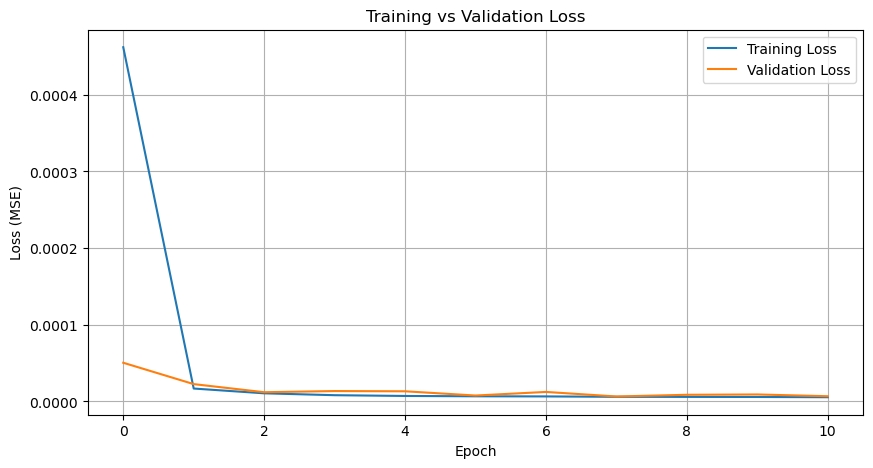

In [13]:
import matplotlib.pyplot as plt

# Plot the training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.title('Training vs Validation Loss')
plt.legend()  
plt.grid(True)  
plt.show()  


323/323 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


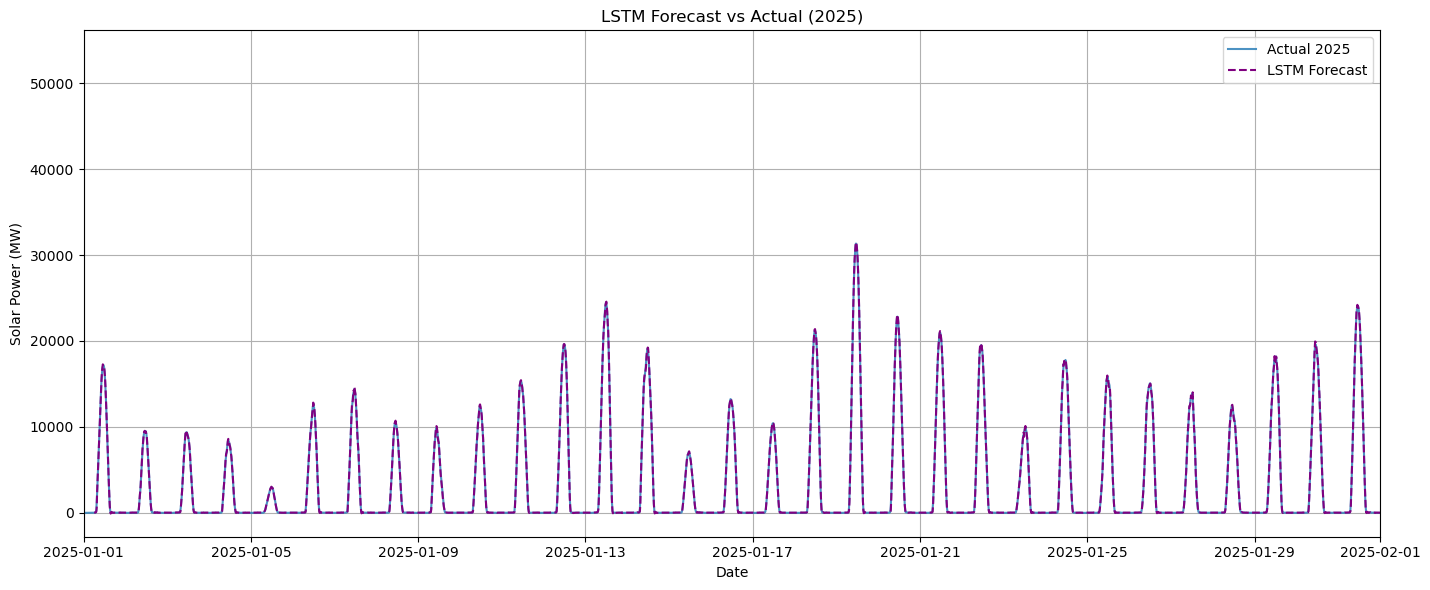

LSTM → MAE: 72.16, RMSE: 130.60


In [14]:
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error
import pandas as pd
import numpy as np

# Predict using the trained model
pred_scaled = model.predict(X_test)

# Inverse transform to original scale
pred_lstm = scaler.inverse_transform(pred_scaled)

# Create forecast index to align with predictions
forecast_index = test_series.index[window_size:]
lstm_forecast = pd.Series(pred_lstm.flatten(), index=forecast_index)

# Ensure indices are datetime objects
test_series.index = pd.to_datetime(test_series.index)
lstm_forecast.index = pd.to_datetime(lstm_forecast.index)

# Plot actual vs forecast
plt.figure(figsize=(14, 6))
plt.plot(test_series.index, test_series, label="Actual 2025", alpha=0.8)
plt.plot(lstm_forecast.index, lstm_forecast, label="LSTM Forecast", linestyle='--', color='purple')
plt.title("LSTM Forecast vs Actual (2025)")
plt.xlabel("Date")
plt.ylabel("Solar Power (MW)")
plt.legend()
plt.grid(True)
plt.tight_layout()

# Zoom in on a specific date range (adjust as needed)
start_date = pd.to_datetime('2025-01-01')
end_date = pd.to_datetime('2025-02-01')
plt.xlim(start_date, end_date)

plt.show()

# Calculate error metrics
true_values = test_series[window_size:]  # Align with X_test sequences
mae_lstm = mean_absolute_error(true_values, lstm_forecast)
rmse_lstm = np.sqrt(mean_squared_error(true_values, lstm_forecast))

print(f"LSTM → MAE: {mae_lstm:.2f}, RMSE: {rmse_lstm:.2f}")
